In [1]:
import os
import sys

ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
EXPERIMENT_PATH = f"{ROOT_PATH}/experiments/hbo-possibilities"
sys.path.insert(0, ROOT_PATH)

In [2]:
from json import load, dumps, dump
import numpy as np
import matplotlib.pyplot as plt
from src.datasets.oracle import Oracle, OracleRequest
from src.datasets.data_config import HINTSETS, DEFAULT_HINTSET

In [3]:
cached_oracles = {
    "JOB": Oracle(f"{ROOT_PATH}/data/processed/JOB"),
    "tpch_10gb": Oracle(f"{ROOT_PATH}/data/processed/tpch_10gb"),
    "sample_queries": Oracle(f"{ROOT_PATH}/data/processed/sample_queries"),
}

In [4]:
GREEN = "#3f993c"
ORANGE = "#fcaa2f"
BLUE = "cyan"
RED = "#a00d30"

In [5]:
bench_to_title = {
    "JOB": "JOB",
    "sample_queries": "SQ",
    "tpch_10gb": "TPCH"
}

In [6]:
query_dops = [1, 16, 64]

# Total times

In [7]:
def get_best_hintset(oracle, query_name, possible_hintsets, dop):
    assert isinstance(possible_hintsets, list) and len(possible_hintsets)
    best_time, best_hs = float("inf"), possible_hintsets[0]
    
    for hs in possible_hintsets:
        request = OracleRequest(query_name=query_name, hintset=hs, dop=dop)
        time = oracle.get_execution_time(request=request)
        if time < best_time:
            best_time, best_hs = time, hs

    return best_hs

In [8]:
def get_worst_hintset(oracle, query_name, possible_hintsets, dop):
    assert isinstance(possible_hintsets, list) and len(possible_hintsets)
    worst_time, worst_hs = float("-inf"), possible_hintsets[0]

    for hs in possible_hintsets:
        request = OracleRequest(query_name=query_name, hintset=hs, dop=dop)
        time = oracle.get_execution_time(request=request)
        if worst_time < time:
            worst_time, worst_hs = time, hs

    return worst_hs

In [9]:
def plot_total_times_bar(best_times, def_times, query_dops, title, path_to_save):
    ind = np.arange(len(query_dops))
    width = 0.35       

    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(40, 15))

    _ = ax.bar(ind - width/2, best_times, width, label='Time with Optimal Hintset', color=GREEN)
    _ = ax.bar(ind + width/2, def_times, width, label='Default Time', color=ORANGE)

    ax.set_xlabel('DOP value', fontsize=26)
    ax.set_ylabel('Total Time (sec)',fontsize=26)
    ax.set_title(title, fontsize=30)
    ax.set_xticks(ind)
    ax.tick_params(axis='y', labelsize=26)
    ax.set_xticklabels(query_dops, fontsize=26)
    ax.legend(fontsize=26, loc="upper right")
    ax.grid(True)
    plt.savefig(path_to_save, dpi=700)
    plt.show()
   

JOB [312.98045999999994, 173.79727600000007, 258.5385610000001] [457.1426929999998, 422.380254, 455.28018399999996]


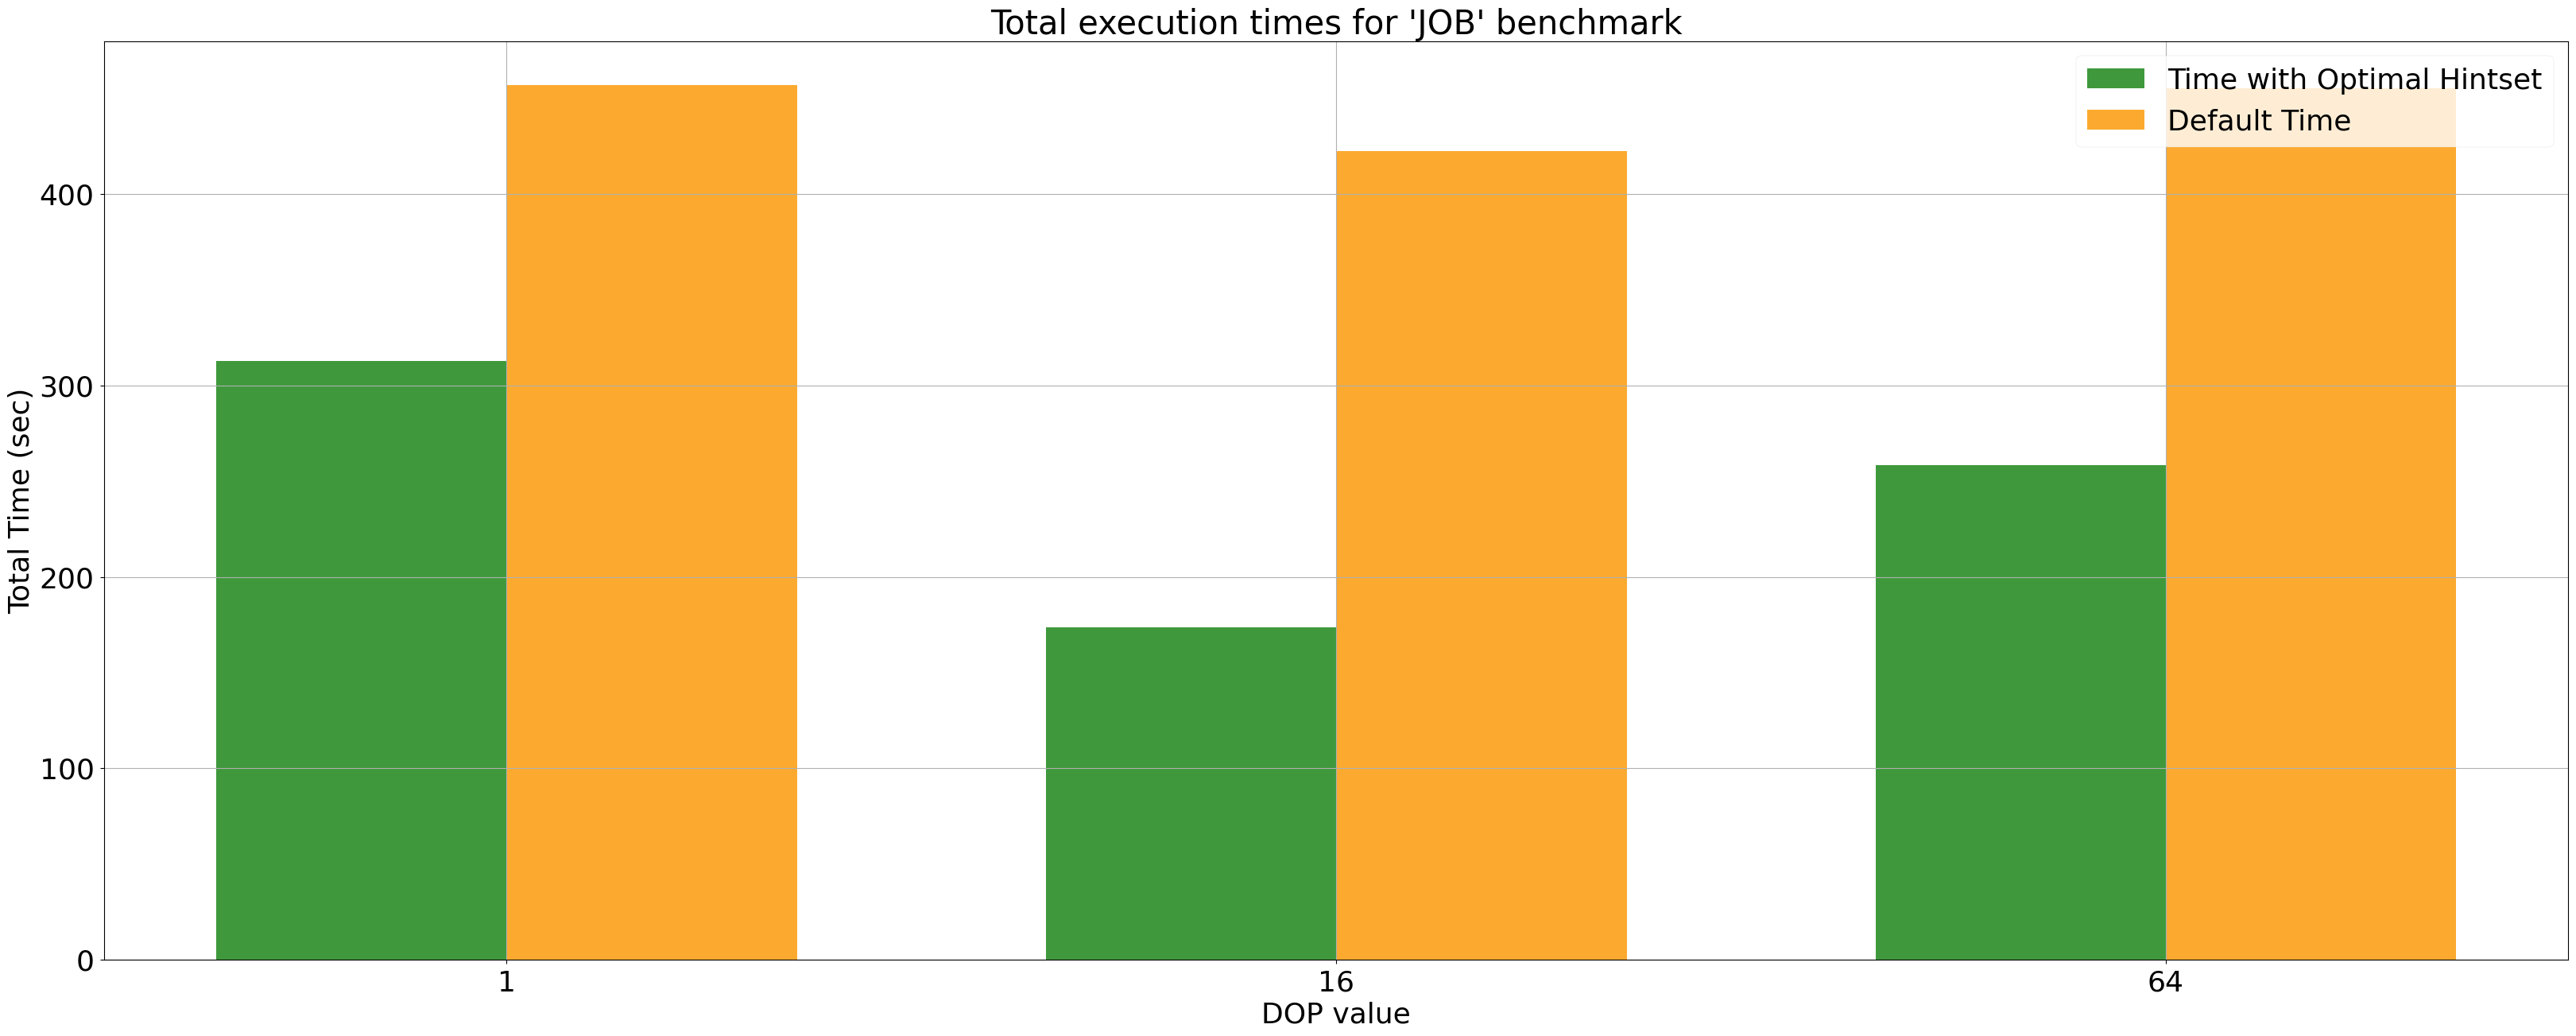

tpch_10gb [473.5769039999999, 390.71111399999995, 388.25646700000004] [596.517831, 494.37088500000004, 514.861666]


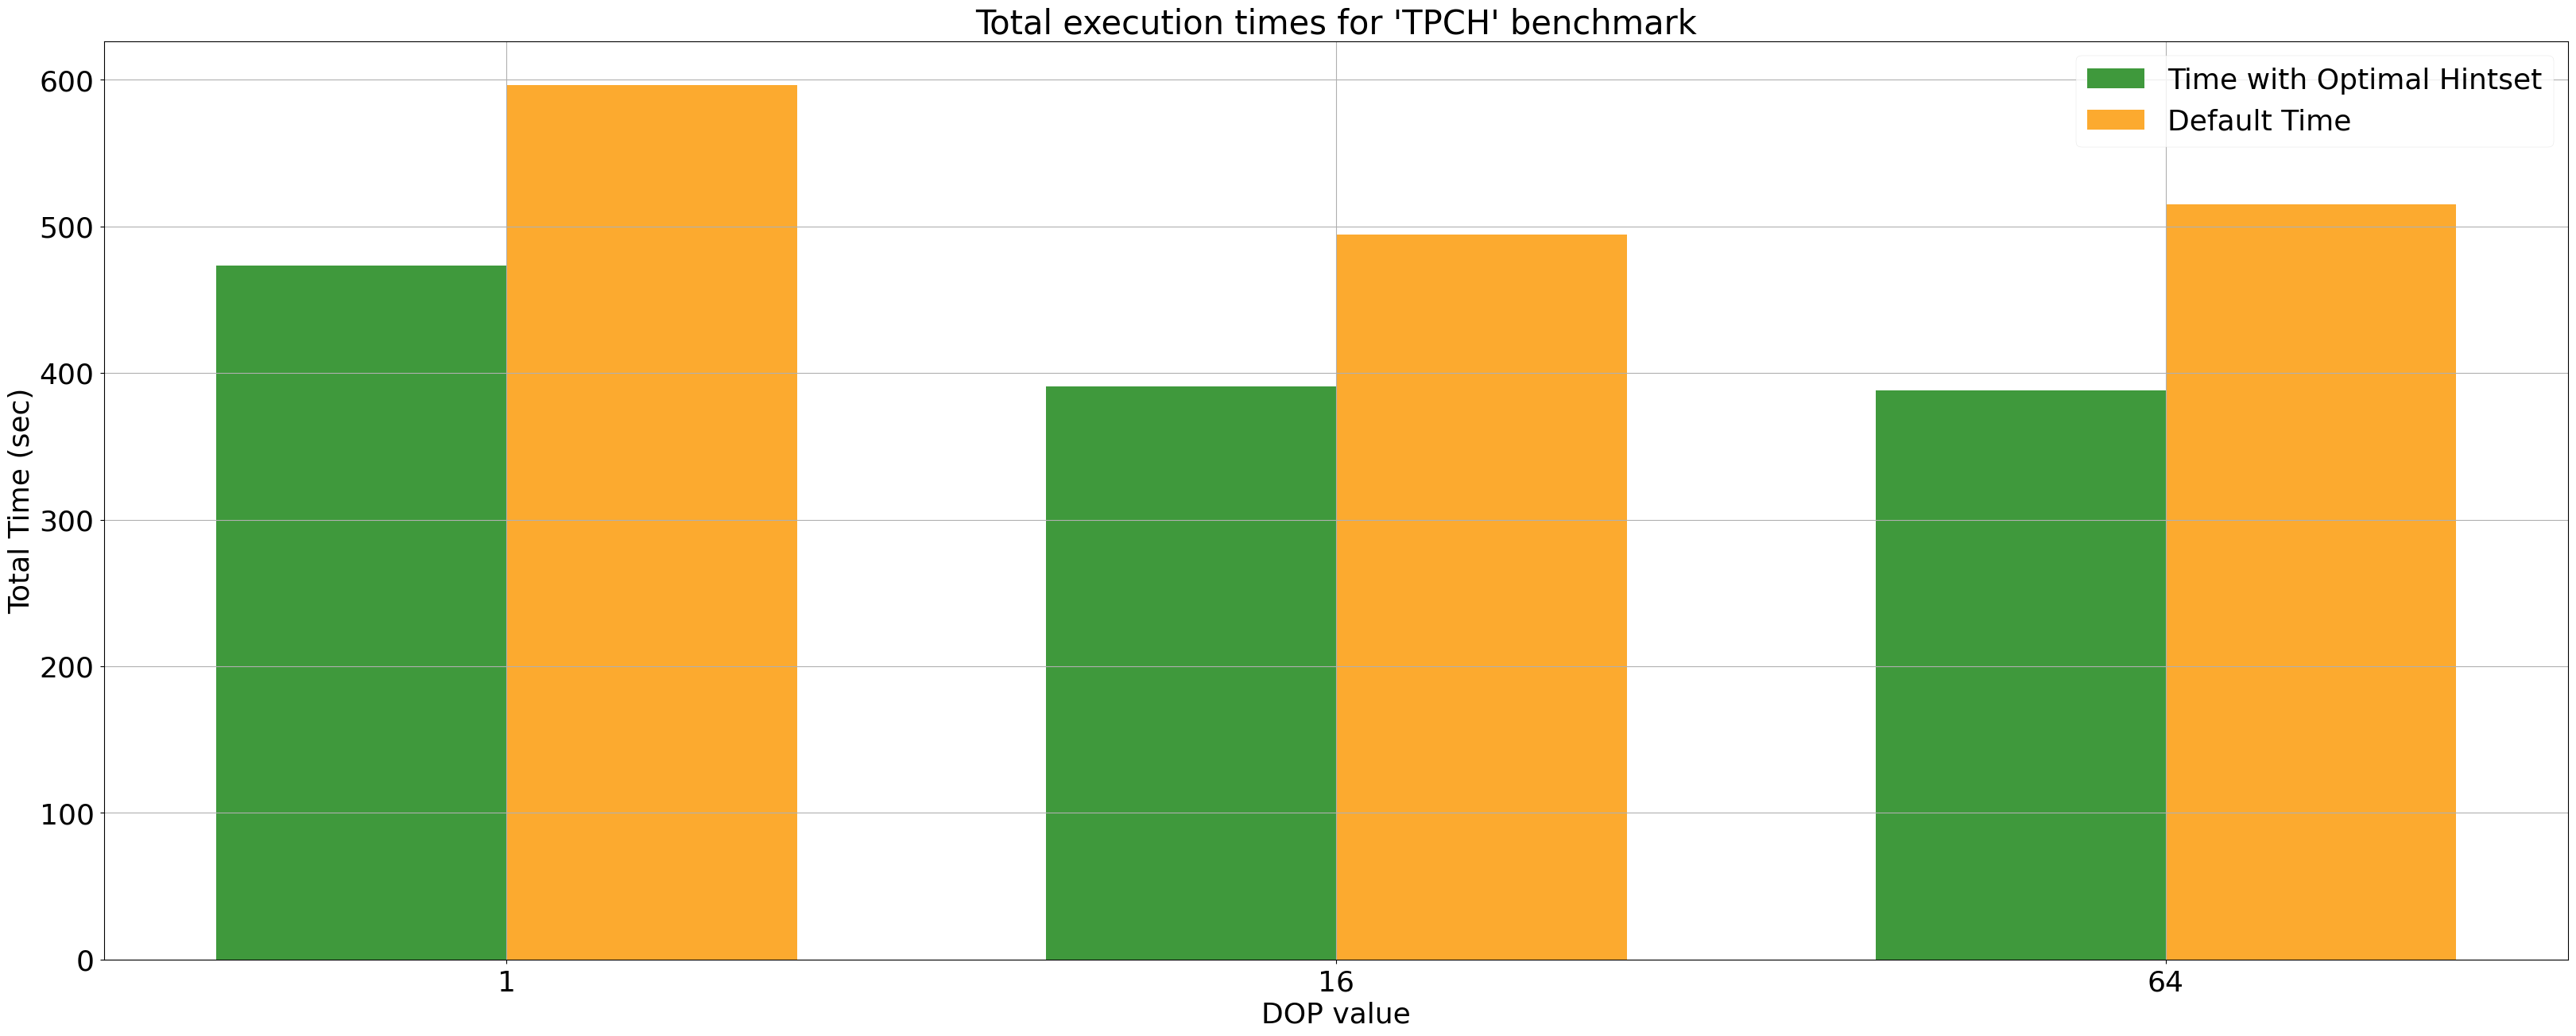

sample_queries [235.21391400000002, 182.02898700000003, 218.524498] [909.9964150000001, 893.607754, 711.5119169999999]


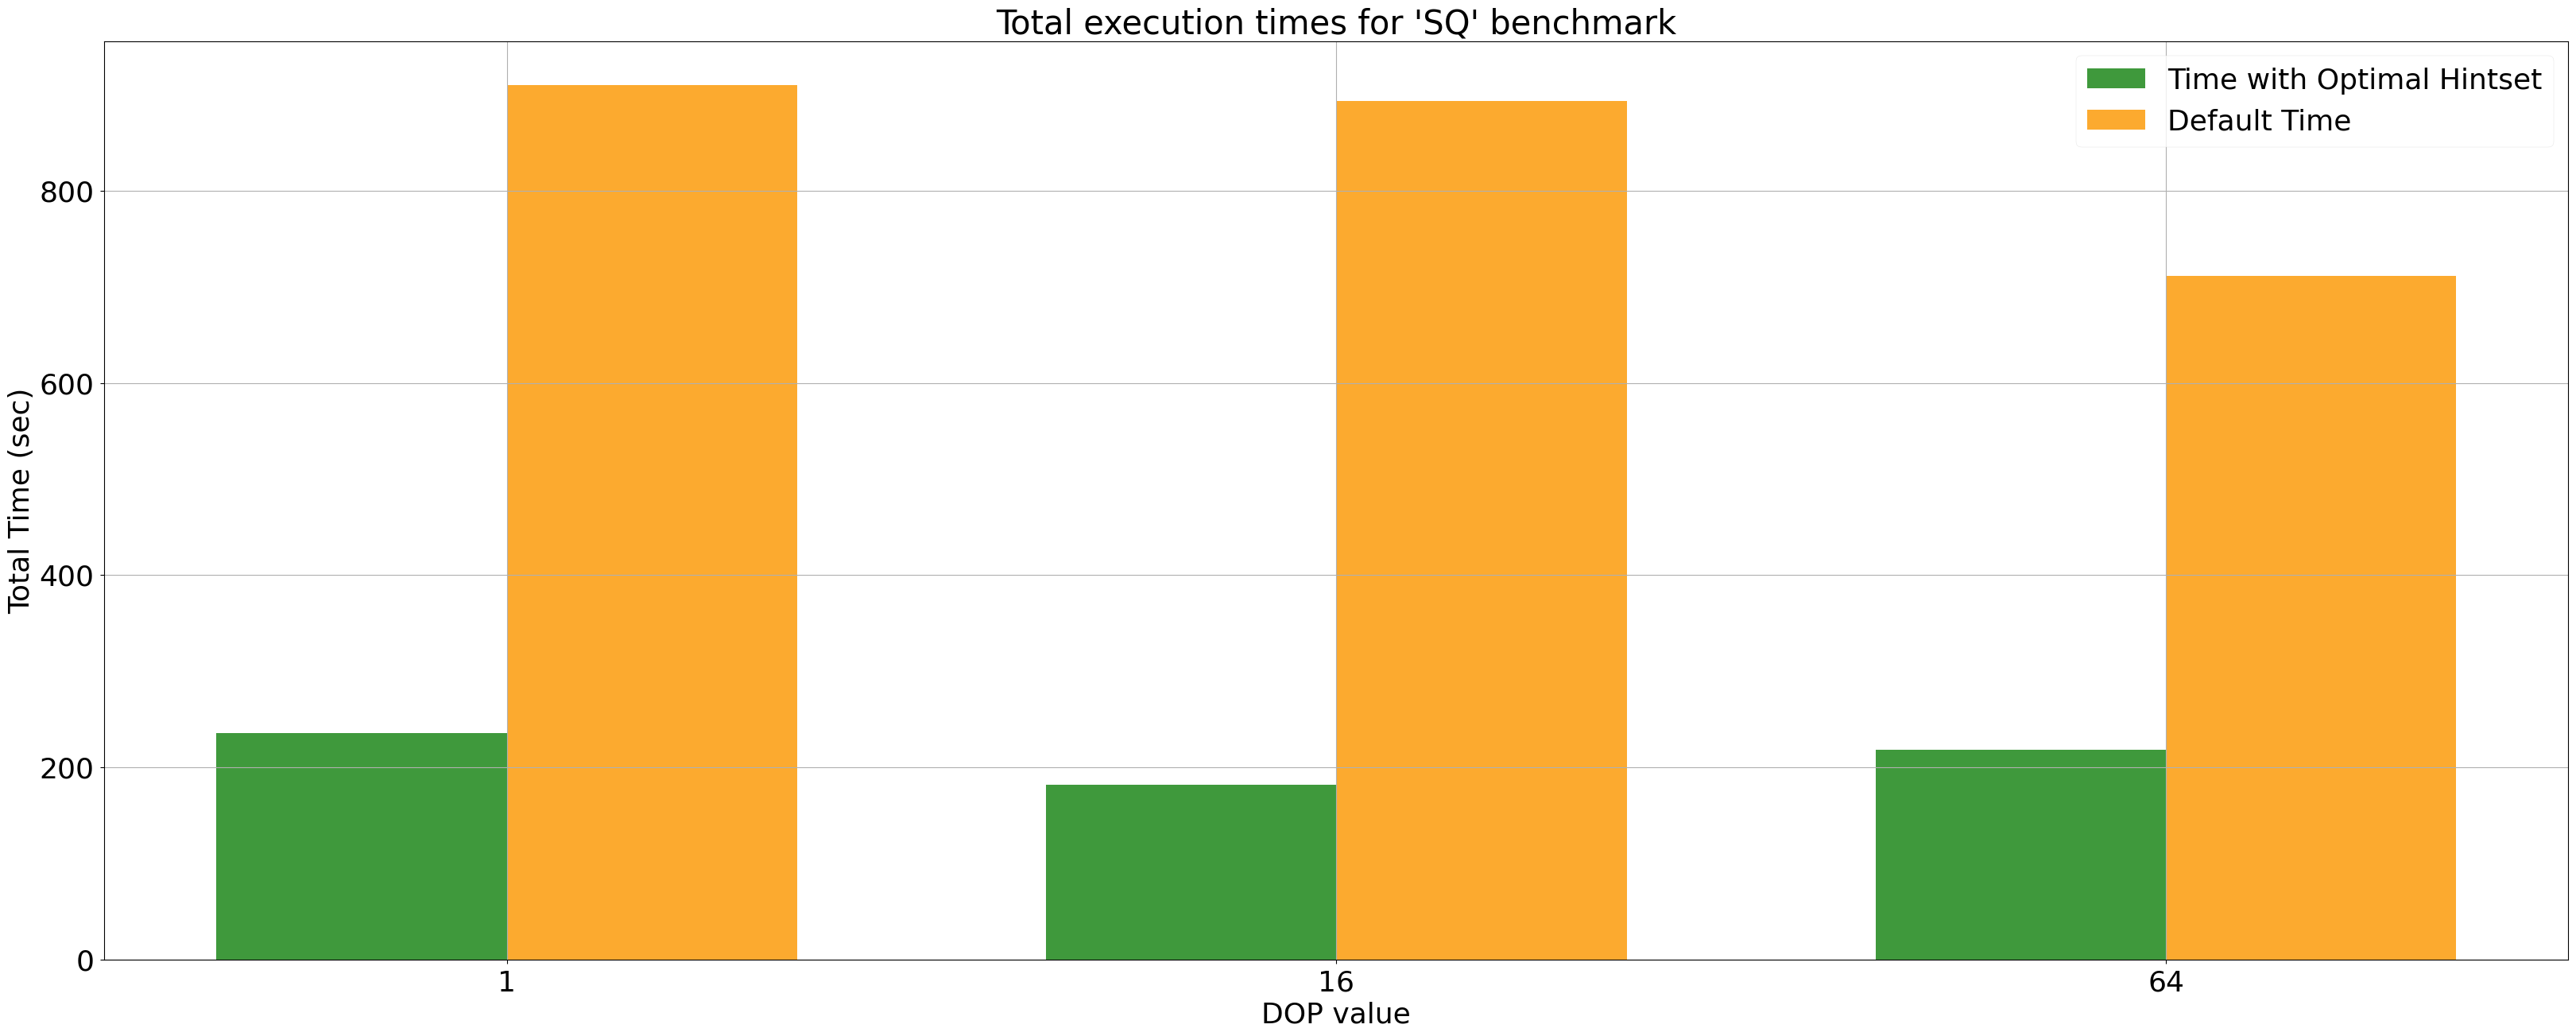

In [77]:
for bench_name, oracle in cached_oracles.items():
    def_times, best_times = [], []
    for dop in query_dops:
        total_def_time, total_best_time = 0, 0
        for query_name in oracle.get_query_names():
            best_hintset = get_best_hintset(
                oracle=oracle, 
                query_name=query_name, 
                possible_hintsets=HINTSETS, 
                dop=dop
            )
            best_request = OracleRequest(query_name=query_name, hintset=best_hintset, dop=dop)
            default_request = OracleRequest(query_name=query_name, hintset=DEFAULT_HINTSET, dop=dop)
            total_best_time += oracle.get_execution_time(best_request)
            total_def_time += oracle.get_execution_time(default_request)

        best_times.append(total_best_time / 1000)
        def_times.append(total_def_time / 1000)
    
    print(bench_name, best_times, def_times)
    bench_title = bench_to_title[bench_name]
    plot_total_times_bar(
        best_times=best_times,
        def_times=def_times,
        query_dops=query_dops,
        title=f"Total execution times for '{bench_title}' benchmark",
        path_to_save=f"{EXPERIMENT_PATH}/artifacts/{bench_title}_total_times.png"
    )

| Benchmark   | dop | Def. Time (s) | Best Time (s) | Boost |
|-------------|-----|---------------|---------------|-------|
| JOB         | 1   | 457.1         | 313.0         | 1.46  |
| JOB         | 16  | 422.4         | 173.8         | 2.43  |
| JOB         | 64  | 455.3         | 258.5         | 1.76  |
| TPCH        | 1   | 596.5         | 473.6         | 1.26  |
| TPCH        | 16  | 494.4         | 390.7         | 1.27  |
| TPCH        | 64  | 514.9         | 388.3         | 1.33  |
| SQ          | 1   | 910.0         | 235.2         | 3.87  |
| SQ          | 16  | 893.6         | 182.0         | 4.91  |
| SQ          | 64  | 711.5         | 218.5         | 3.26  |


# Per query analysis (with regressions)

In [61]:
from src.datasets.oracle import TIMEOUT
TIMEOUT_REL = 2
TIMEOUT_VAL = -3

In [62]:
def _extract_query_number(query_name):
    import re
    return int(re.search(r"-?\d+\.?\d*", query_name).group())

assert _extract_query_number("42abc666") == 42
assert _extract_query_number("q42abc666") == 42
assert _extract_query_number("q042abc666") == 42

In [75]:
def plot_per_query_bars(names, boosts, degradations, title, path_to_save):
    index = np.arange(len(names))
    bar_width = 0.7

    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(40, 15))
    
    timeout_index = [index[i] for i, degr in enumerate(degradations) if degr == TIMEOUT_REL]
    degradation_index = [index[i] for i, degr in enumerate(degradations) if degr != TIMEOUT_REL]
    degradation_vals = [-degr for i, degr in enumerate(degradations) if degr != TIMEOUT_REL]
    
    boost_bars = ax.bar(index, boosts, bar_width, label='Max Boost', color=GREEN)
    if timeout_index:
        timeout_bars = ax.bar(timeout_index, [TIMEOUT_VAL for _ in timeout_index], bar_width, label='Timeout', color=RED)
    if degradation_index:
        degrade_bars = ax.bar(degradation_index, degradation_vals, bar_width, label='Max Degradation', color=ORANGE)
    
    left_edge = index[0] - bar_width / 2
    right_edge = index[-1] + bar_width / 2
    ax.plot([left_edge, right_edge], [1.0, 1.0], color='black', linewidth=2.5, linestyle='-', label='Default Time', alpha=0.8)
    ax.plot([left_edge, right_edge], [-1.0, -1.0], color='black', linewidth=2.5, linestyle='-', alpha=0.8)
    ax.plot([left_edge, right_edge], [0.0, 0.0], color='white', linewidth=4, linestyle='-')


    ax.set_yscale("symlog")
    ax.set_xlabel('Query', fontsize=26)
    ax.set_ylabel('Relative Performance (log scale)',fontsize=26)
    ax.set_title(title, fontsize=30)
    ax.set_xticks(index)
    ax.tick_params(axis='y', labelsize=26)
    ax.set_xticklabels(names, rotation=90, fontsize=22)
    ax.legend(fontsize=26, loc="upper right")
    ax.grid(True, which='both', linestyle='-', linewidth=0.3)
    plt.savefig(path_to_save, dpi=700)
    plt.show()
   

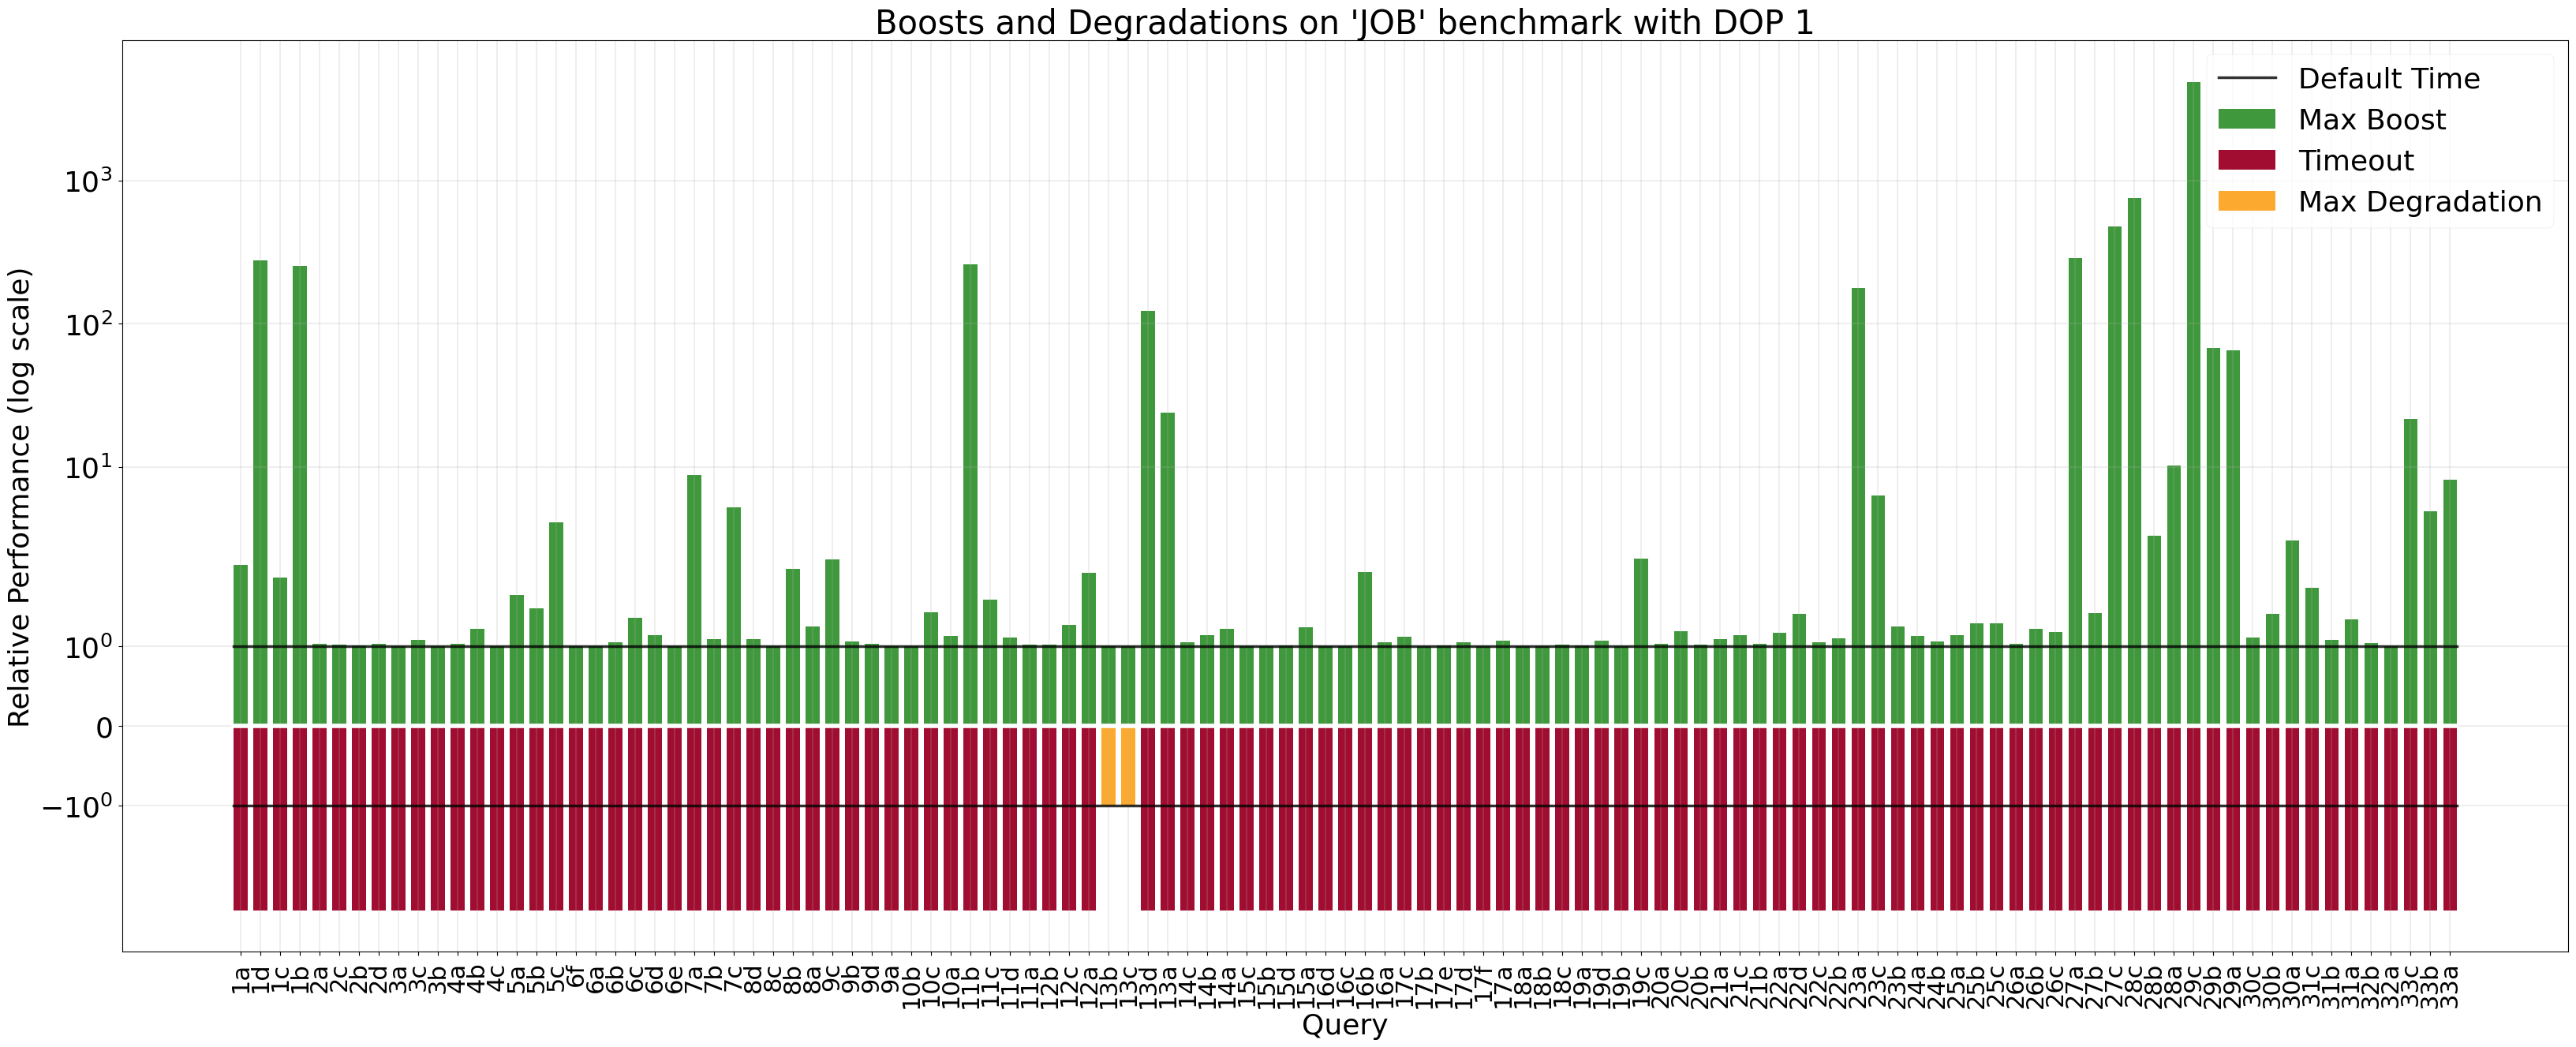

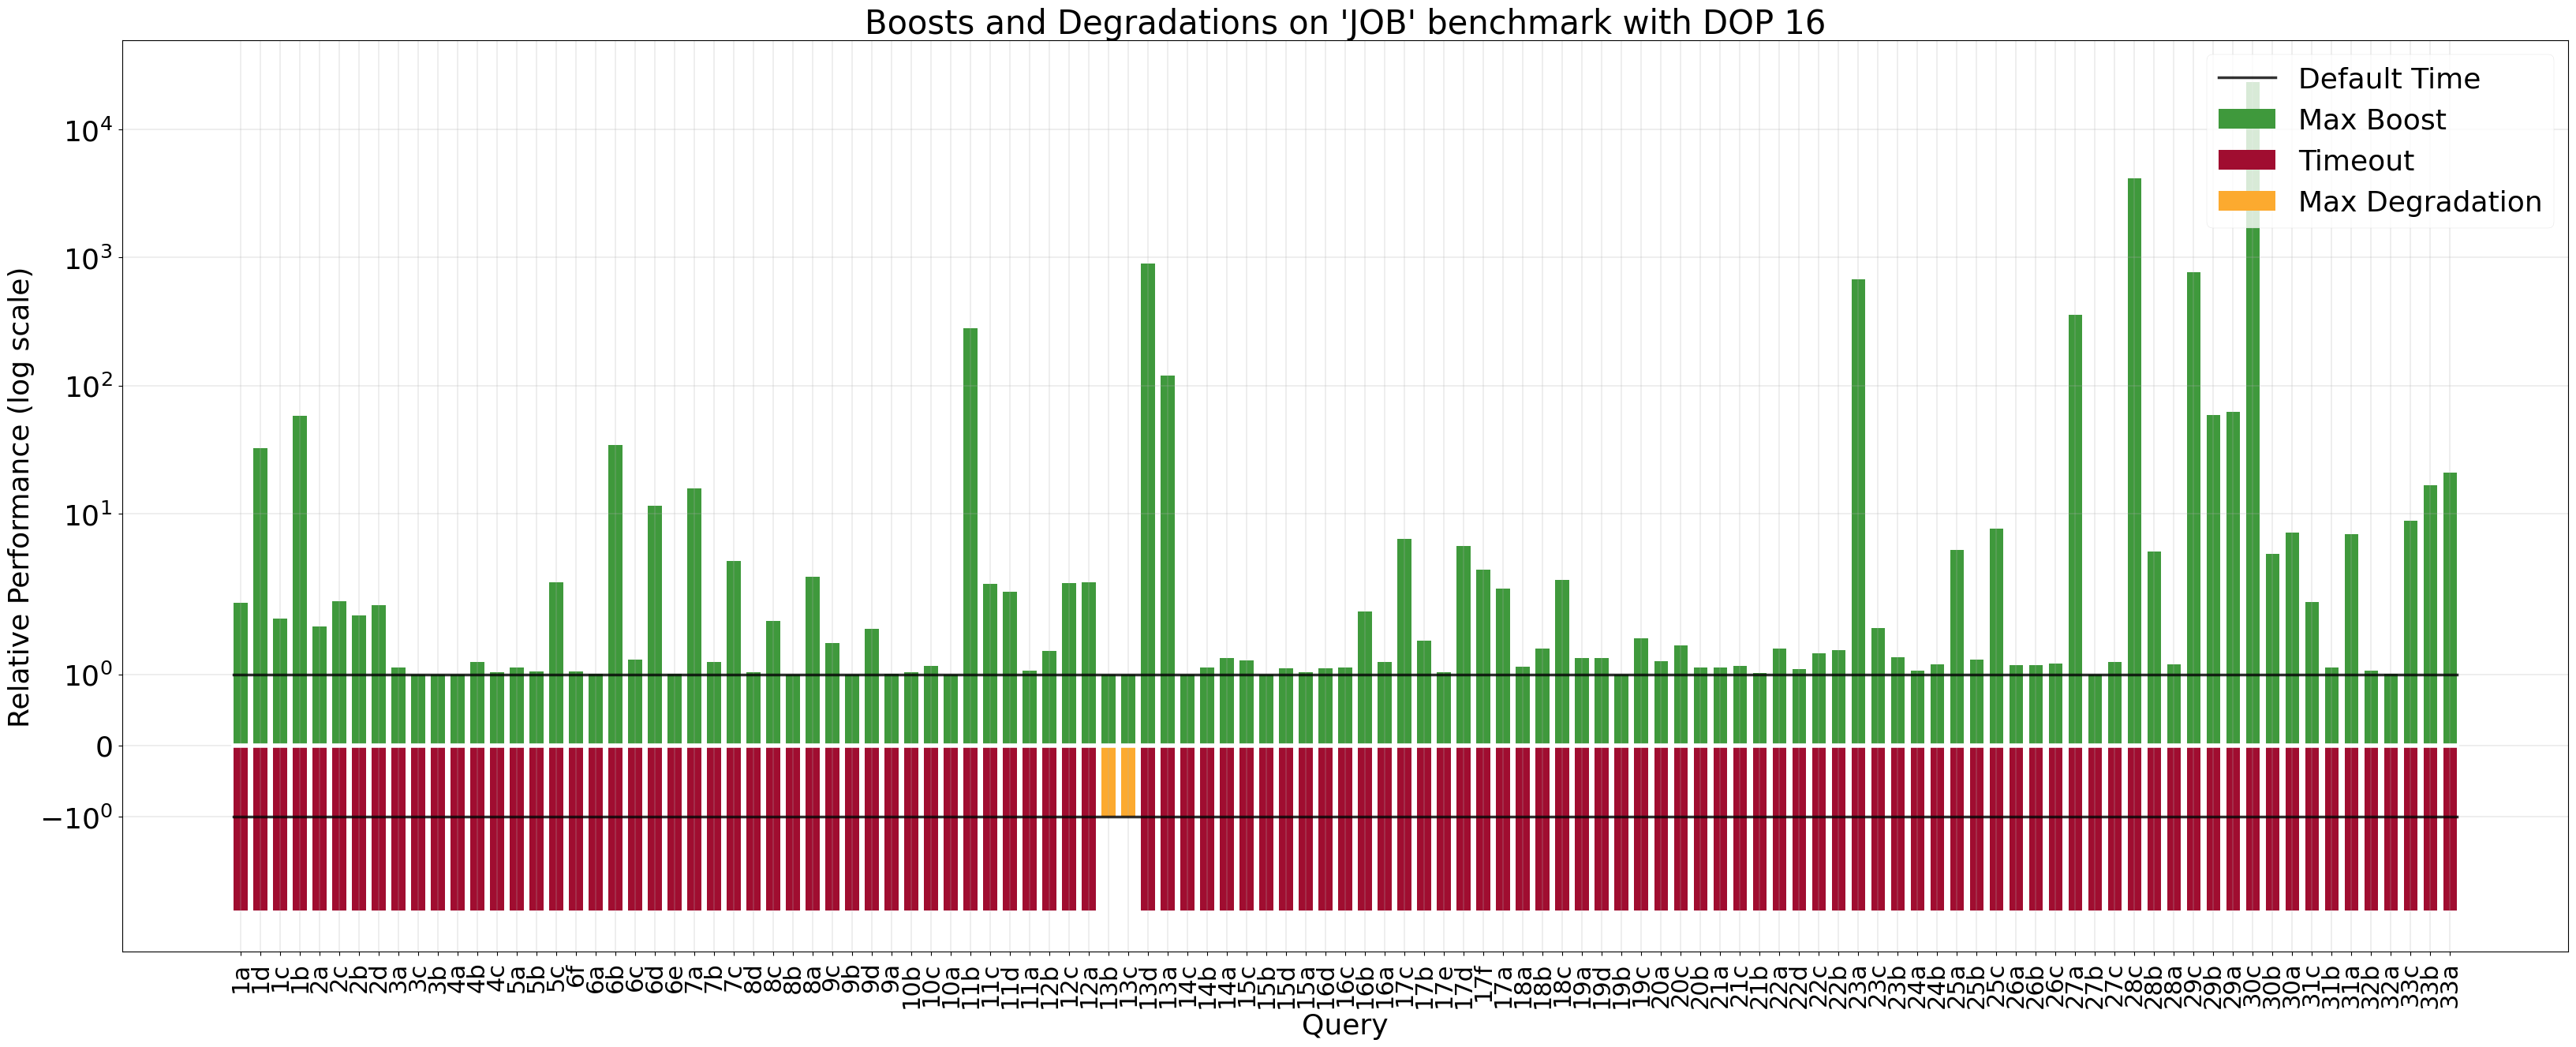

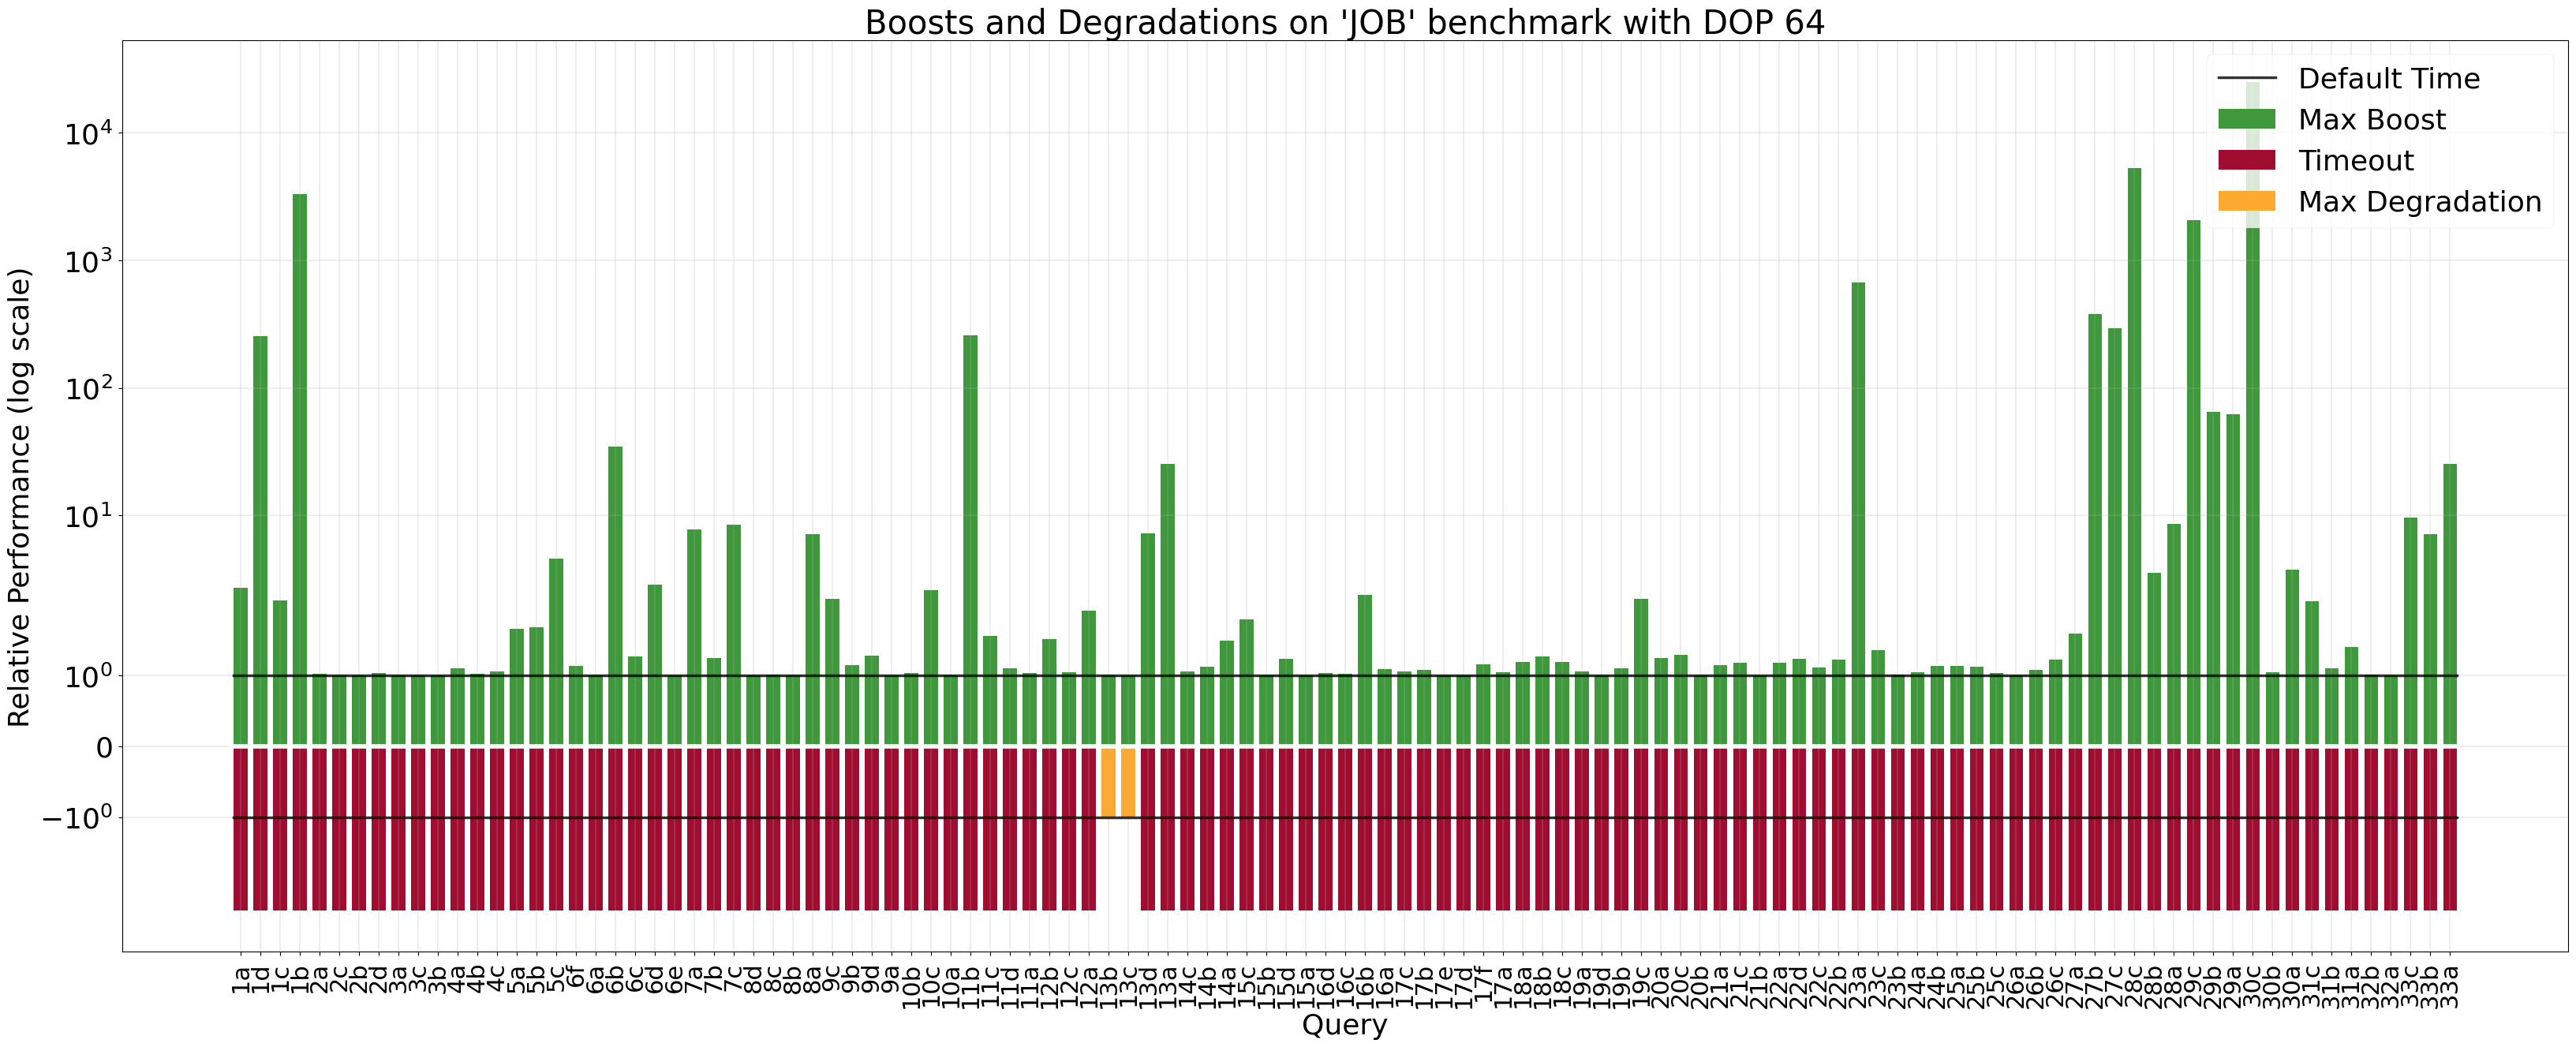

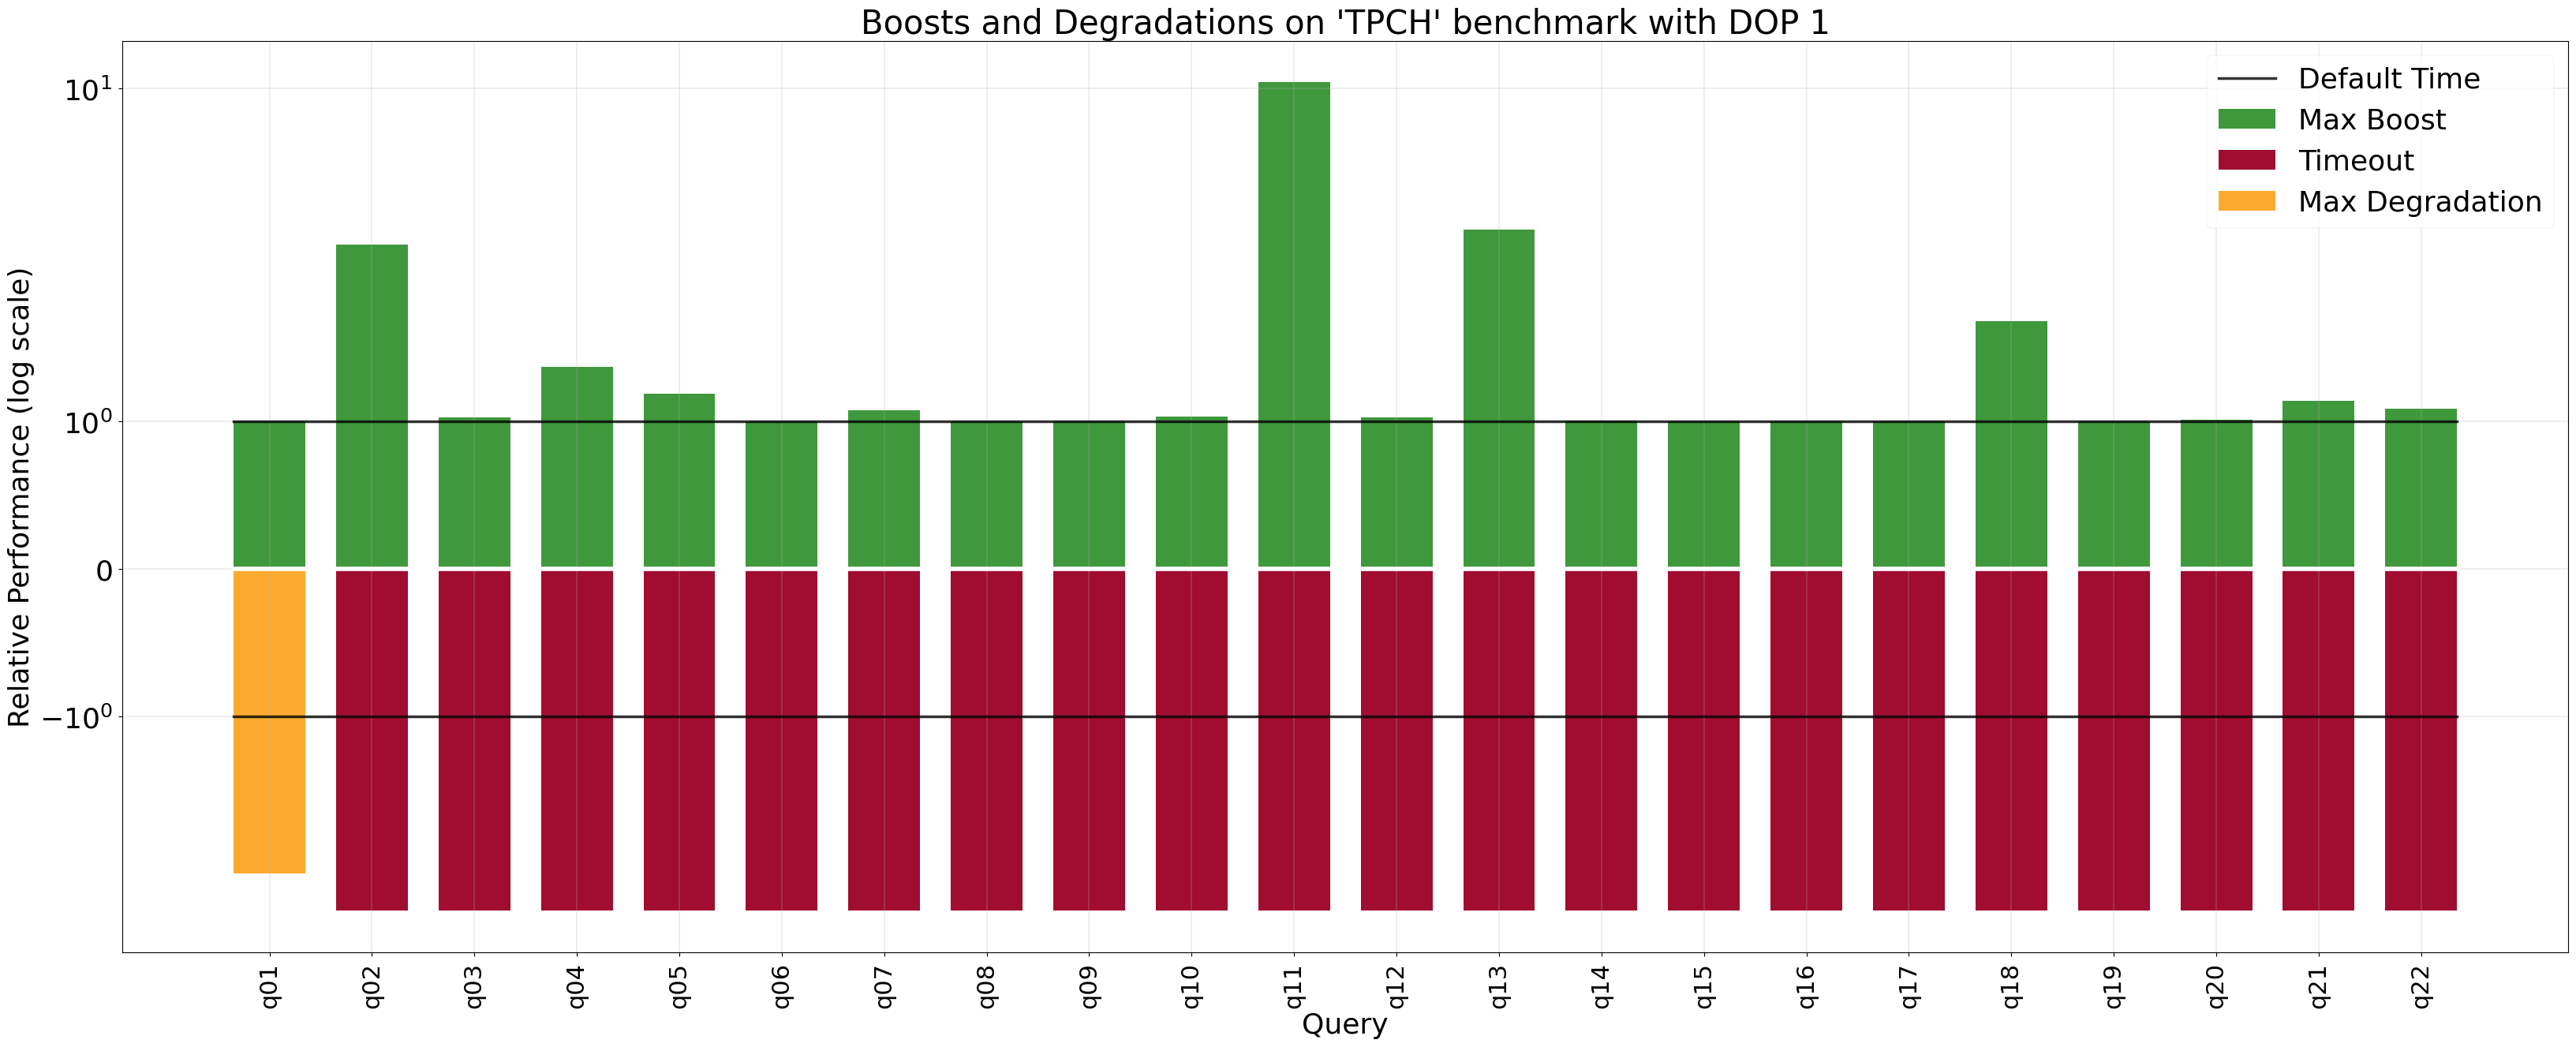

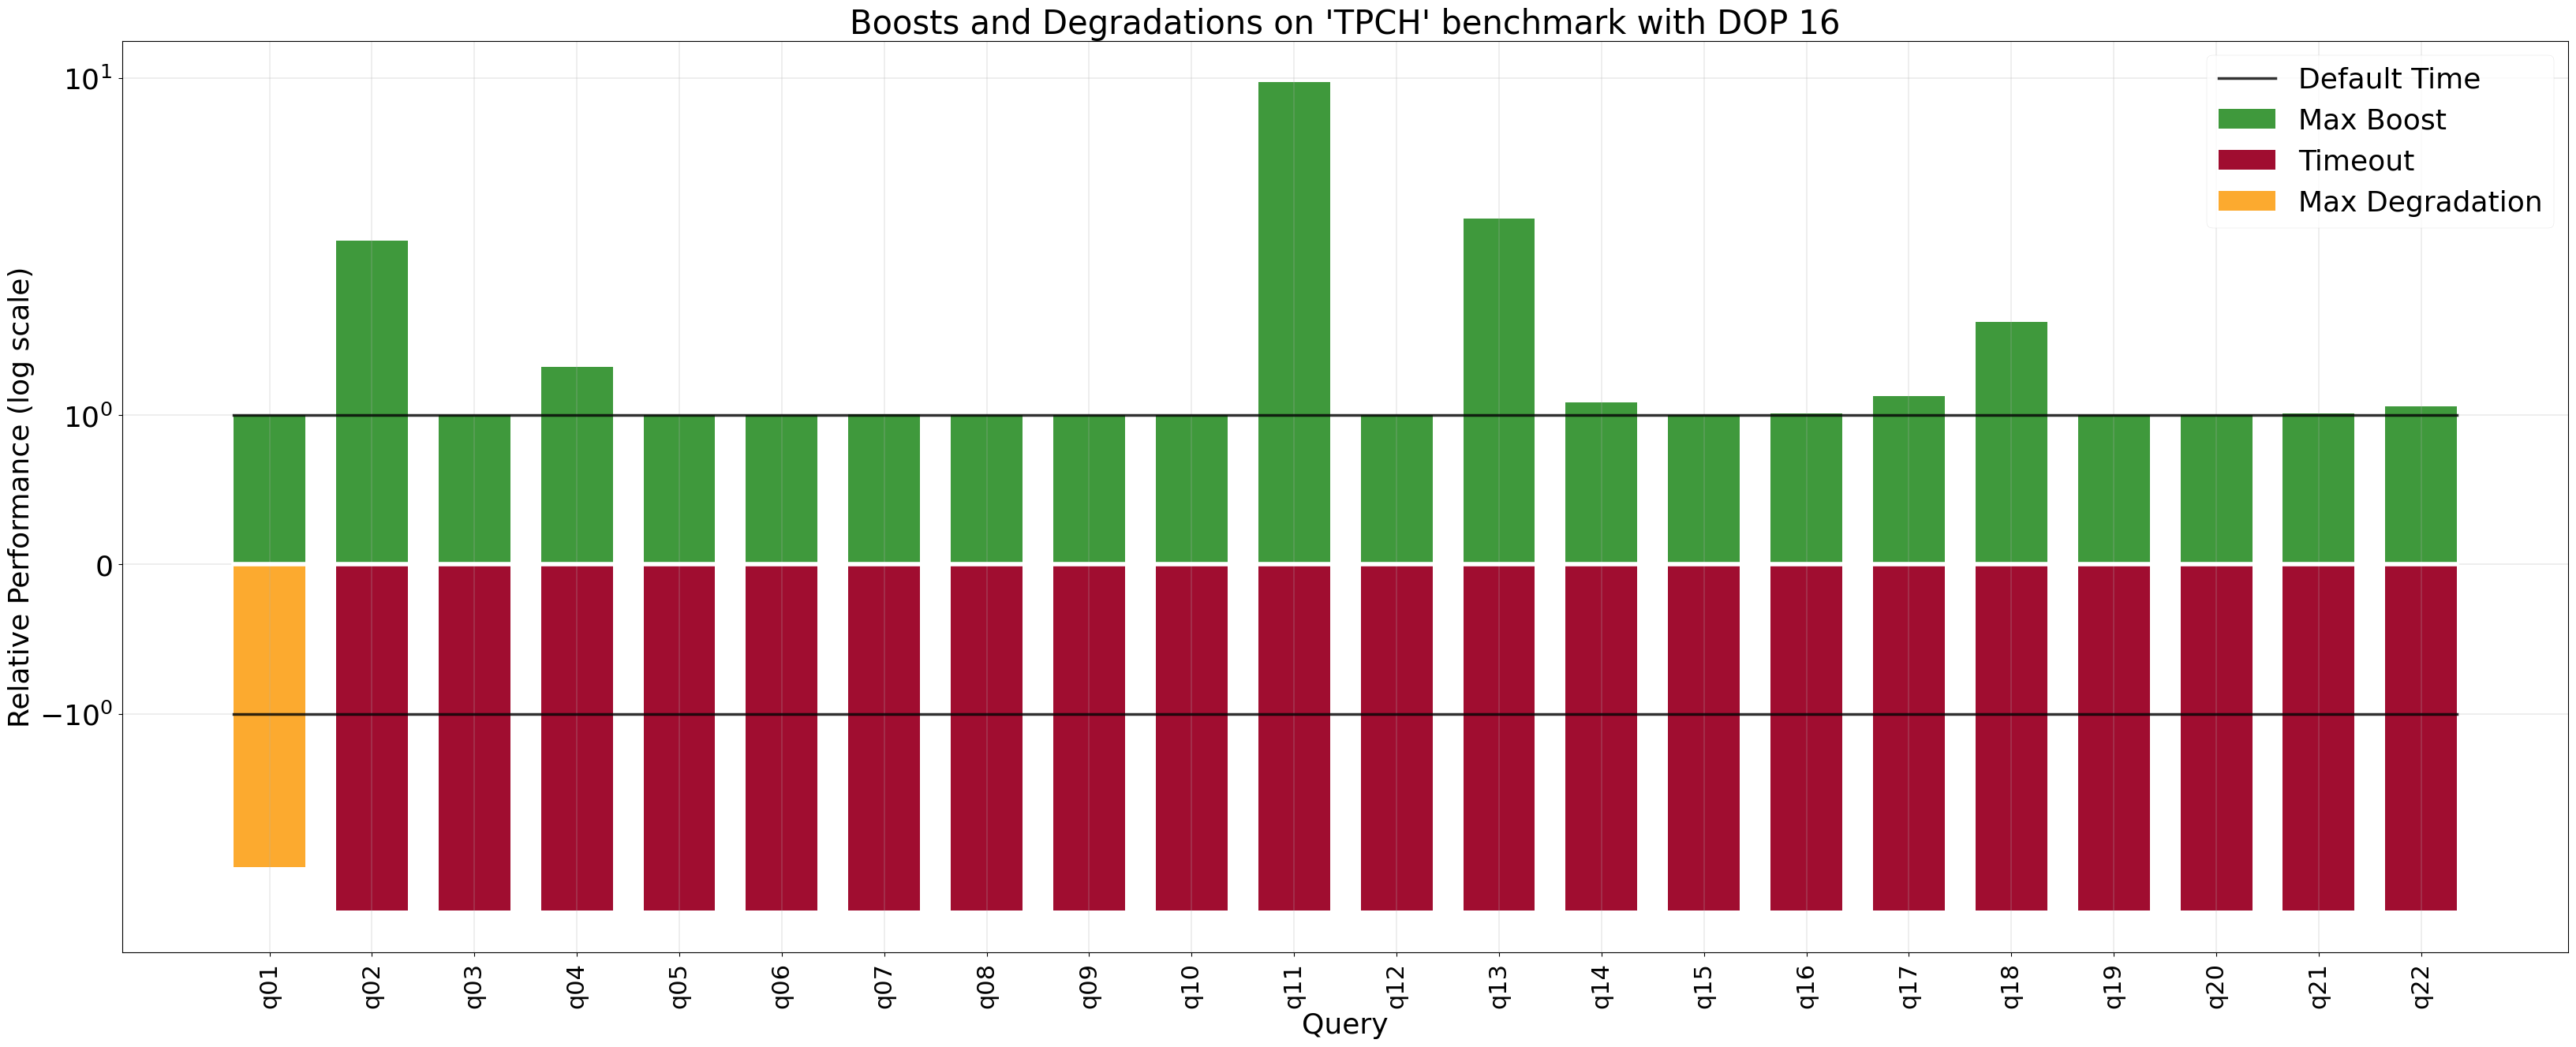

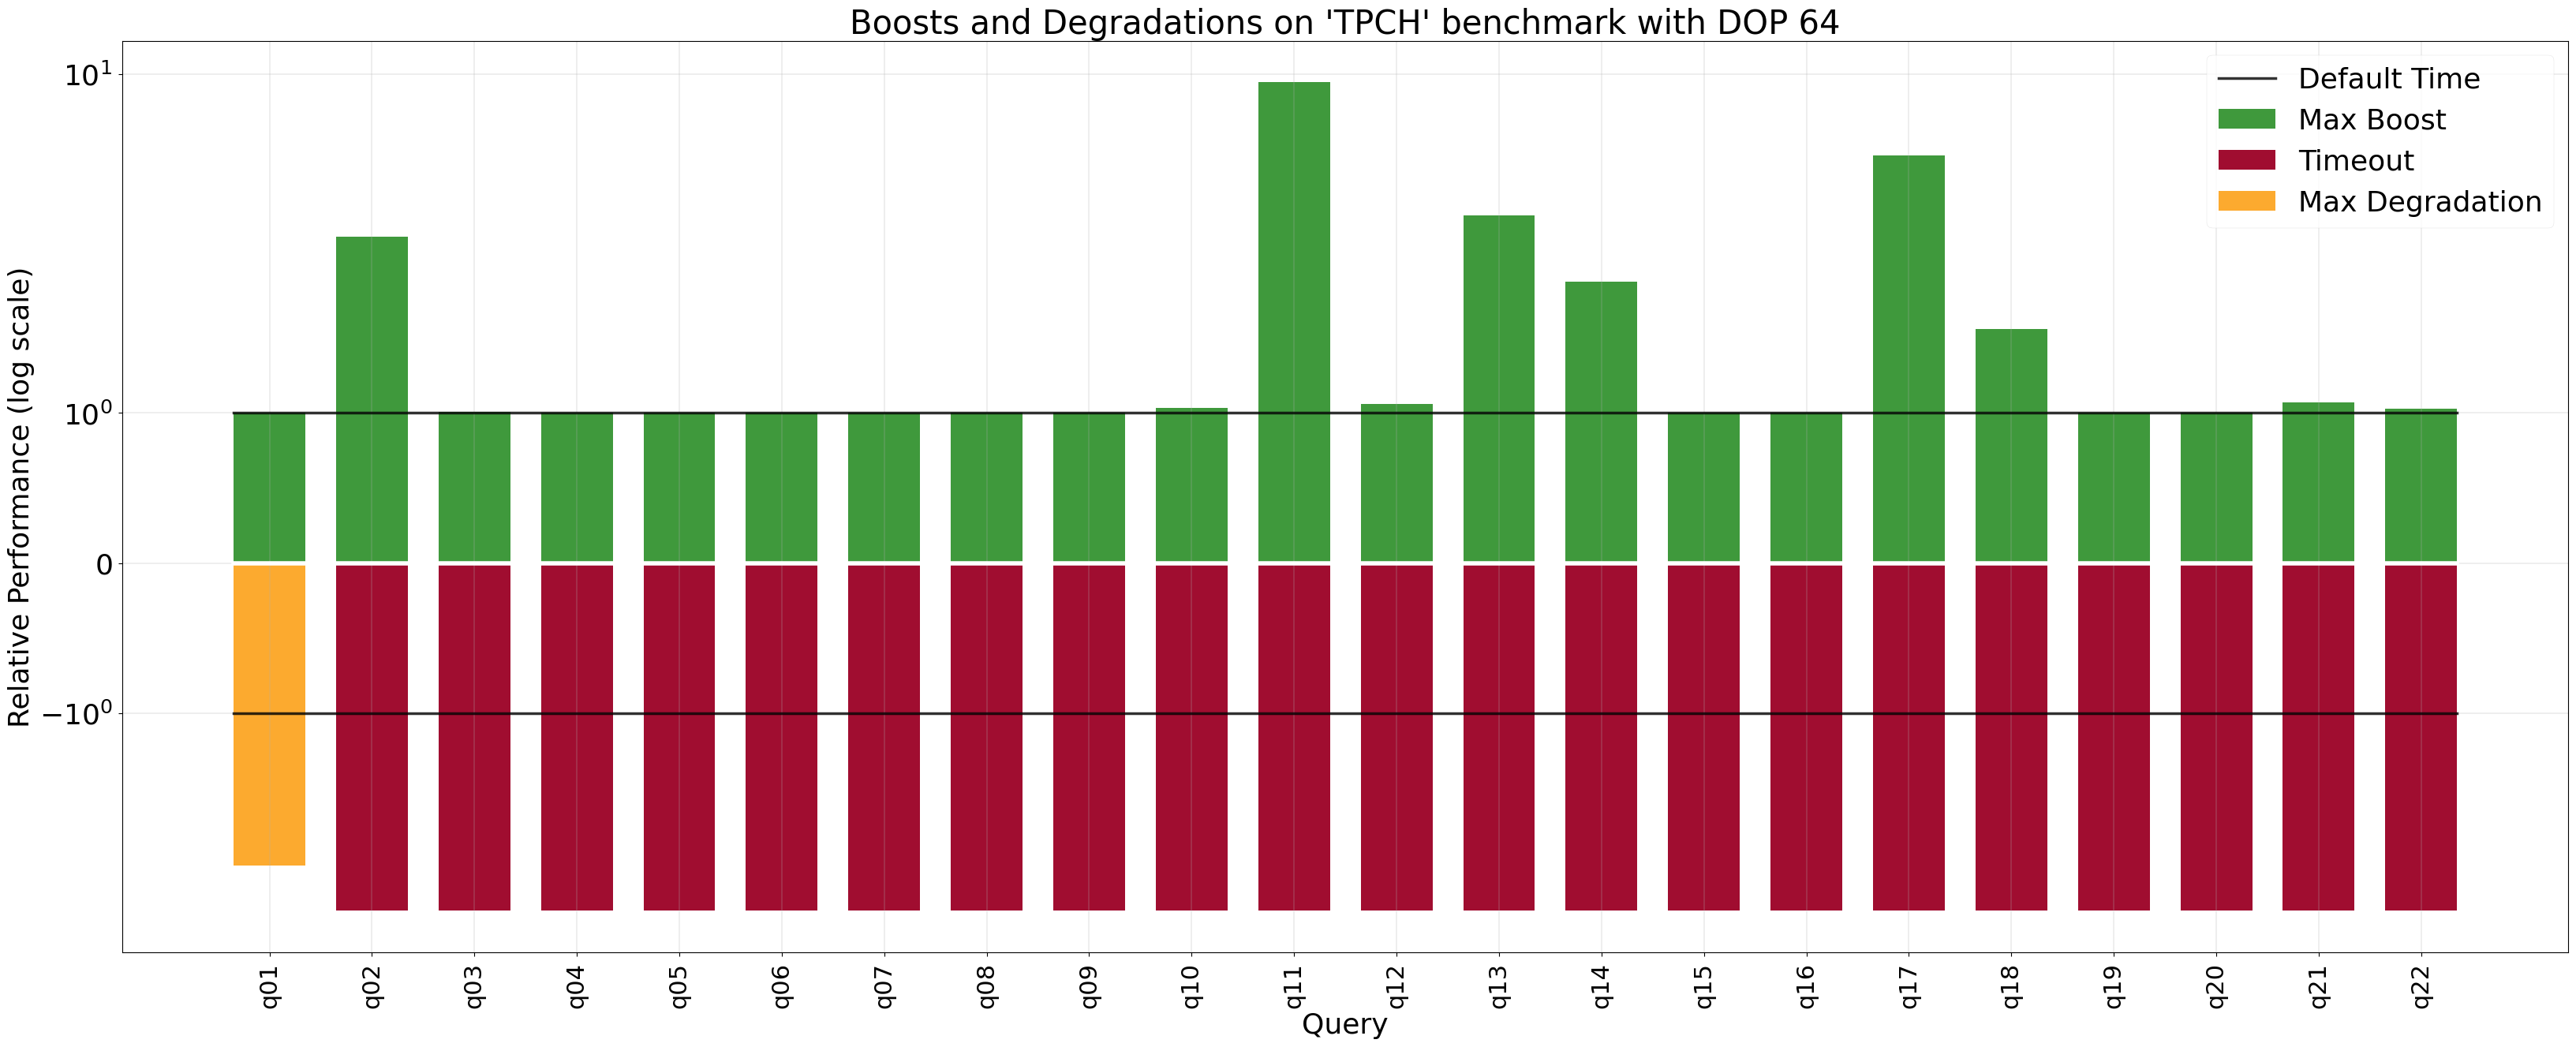

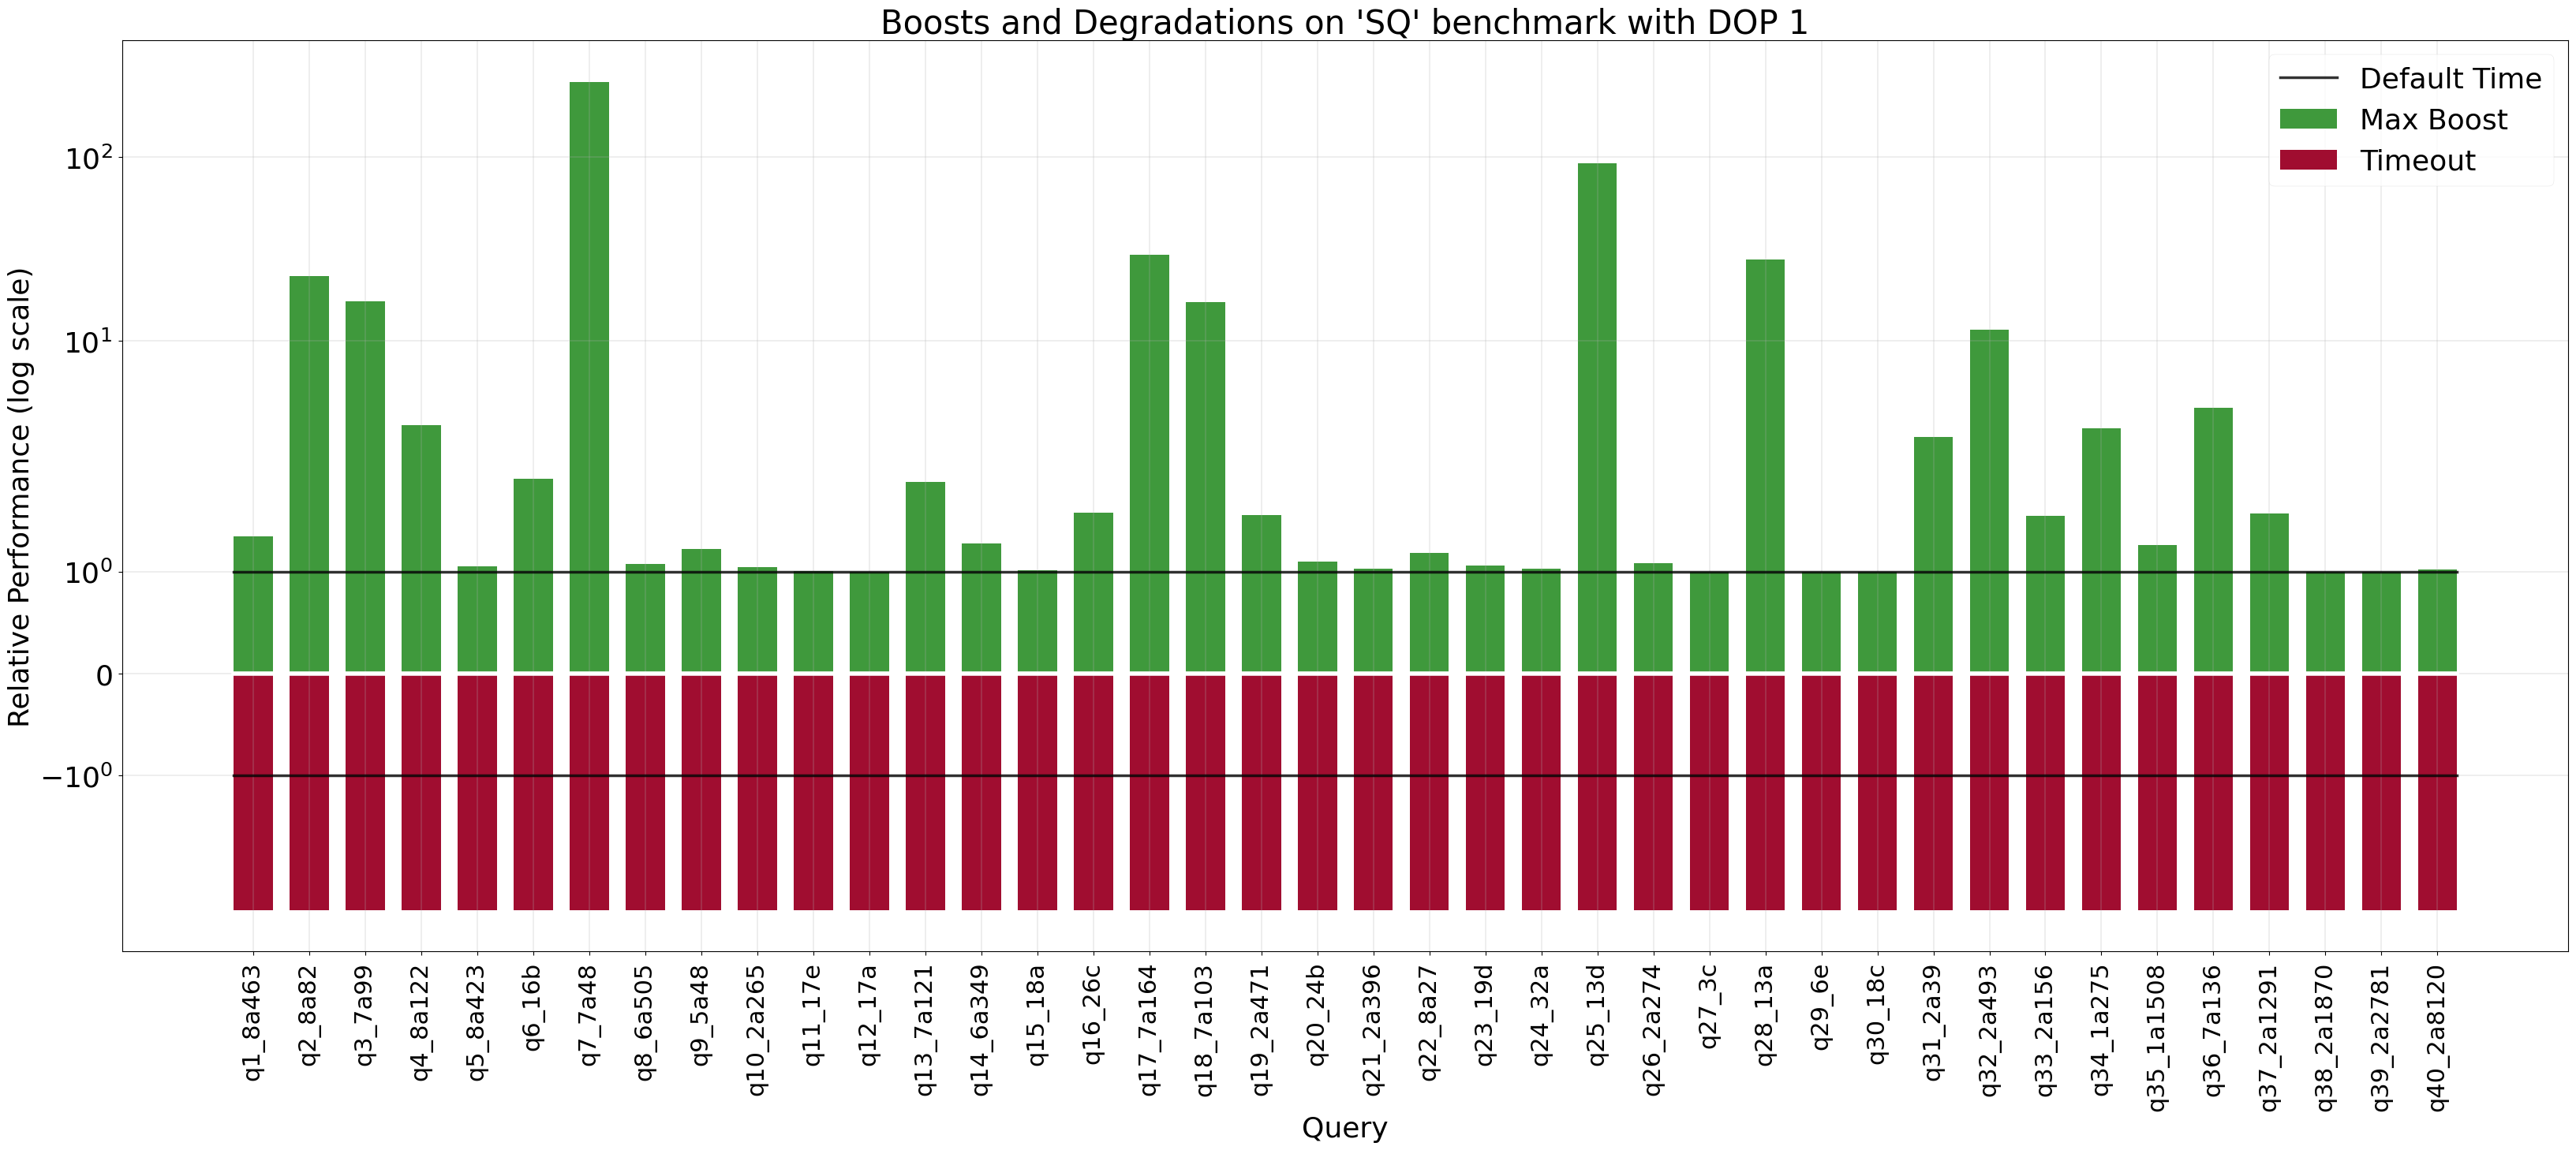

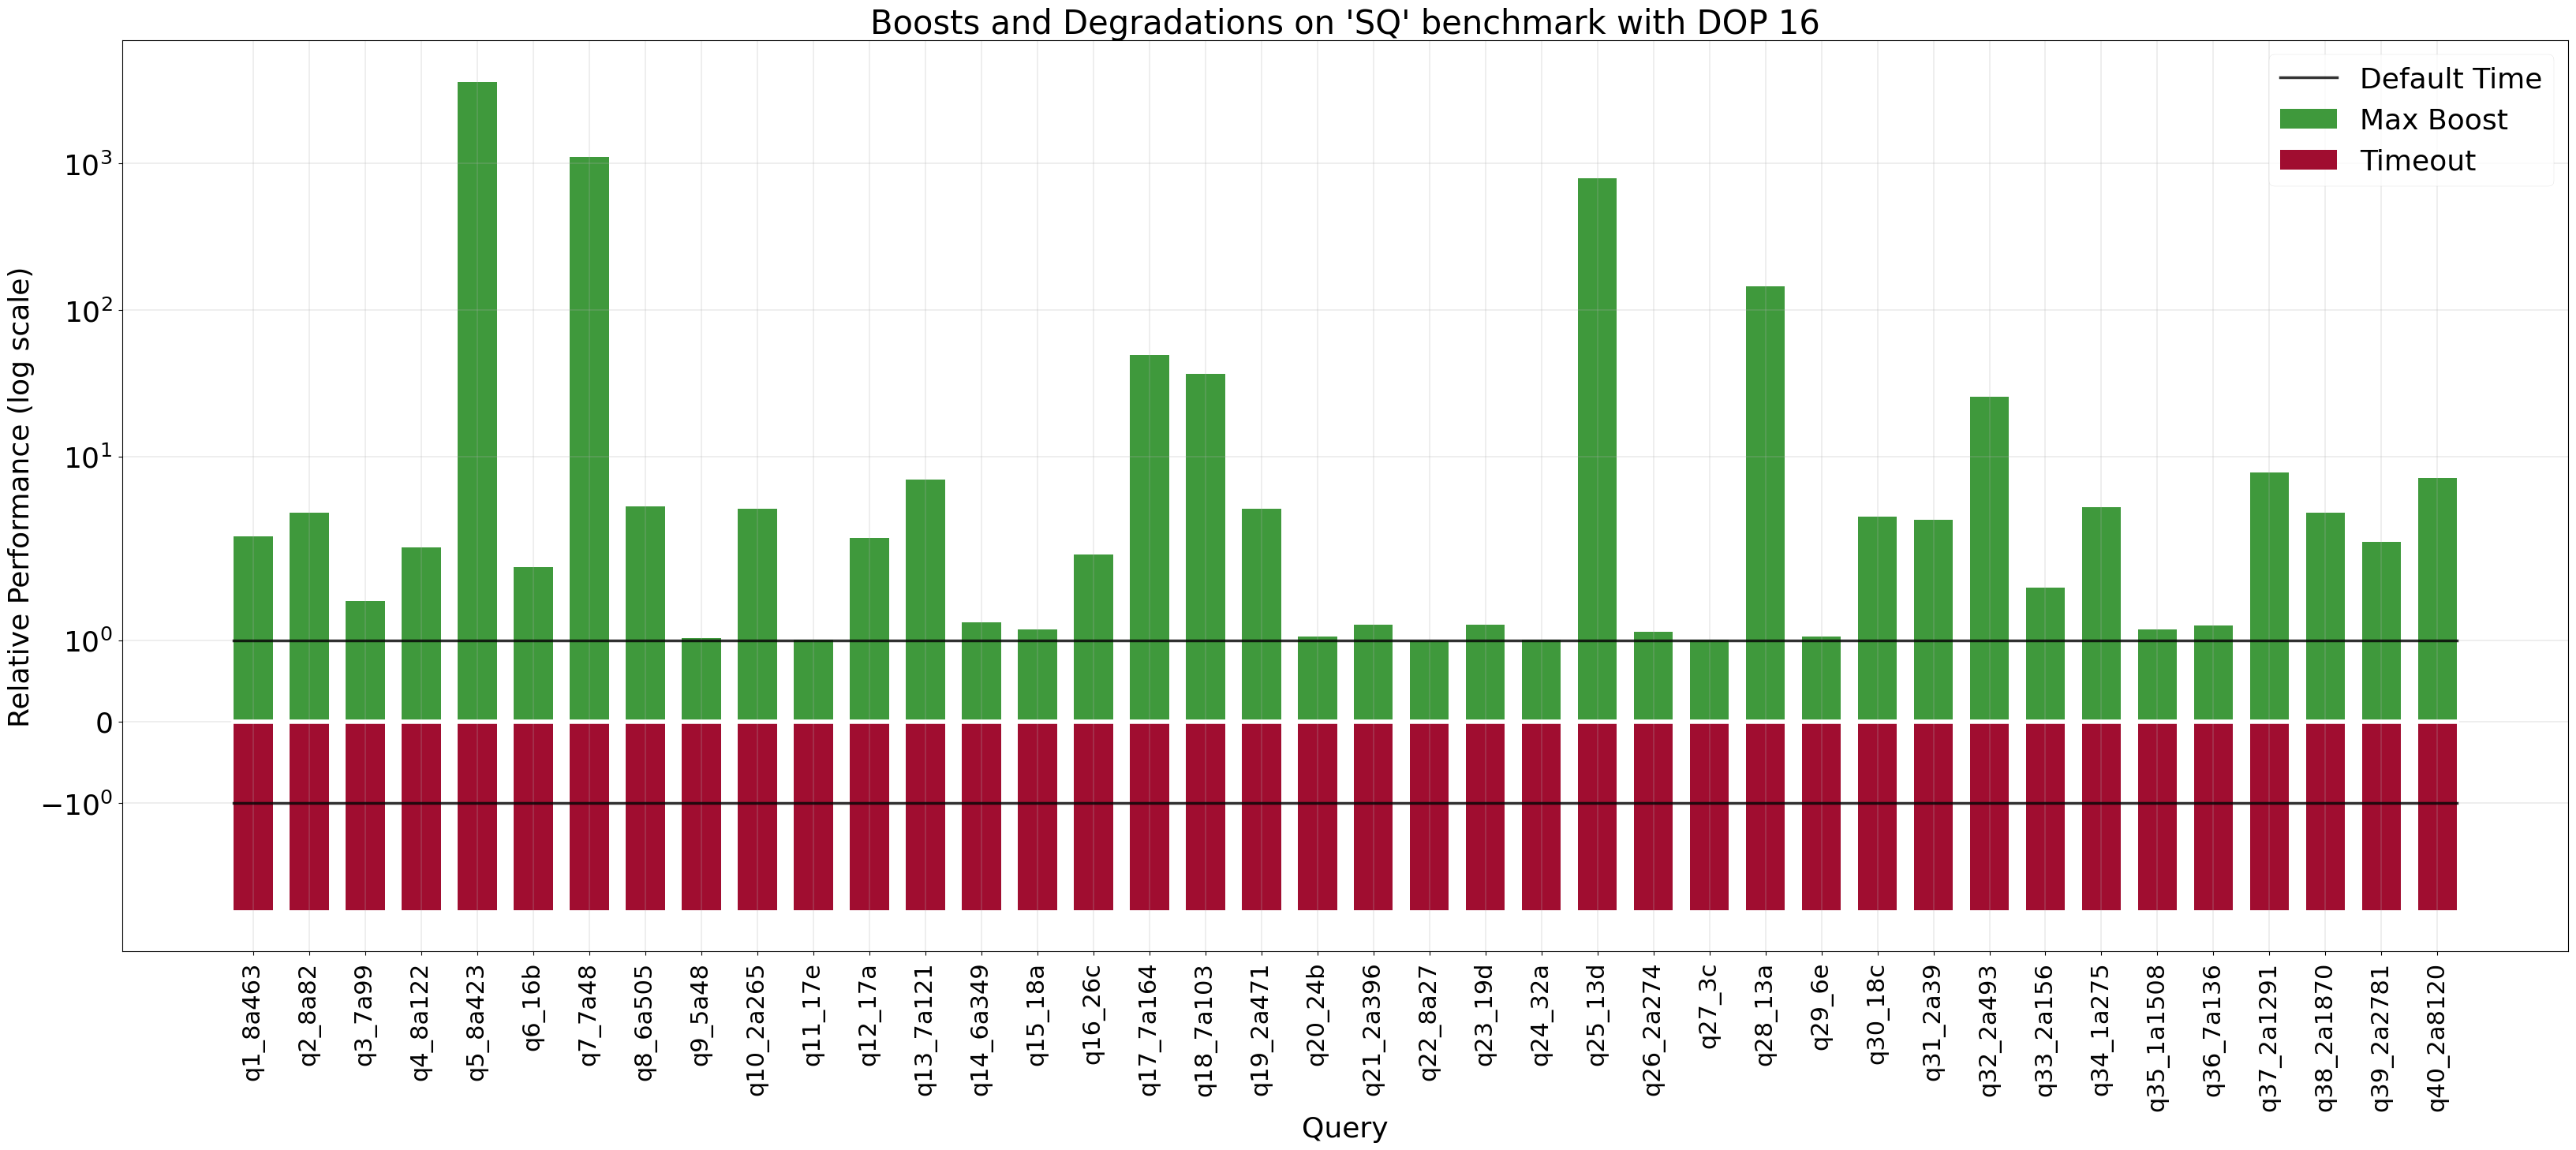

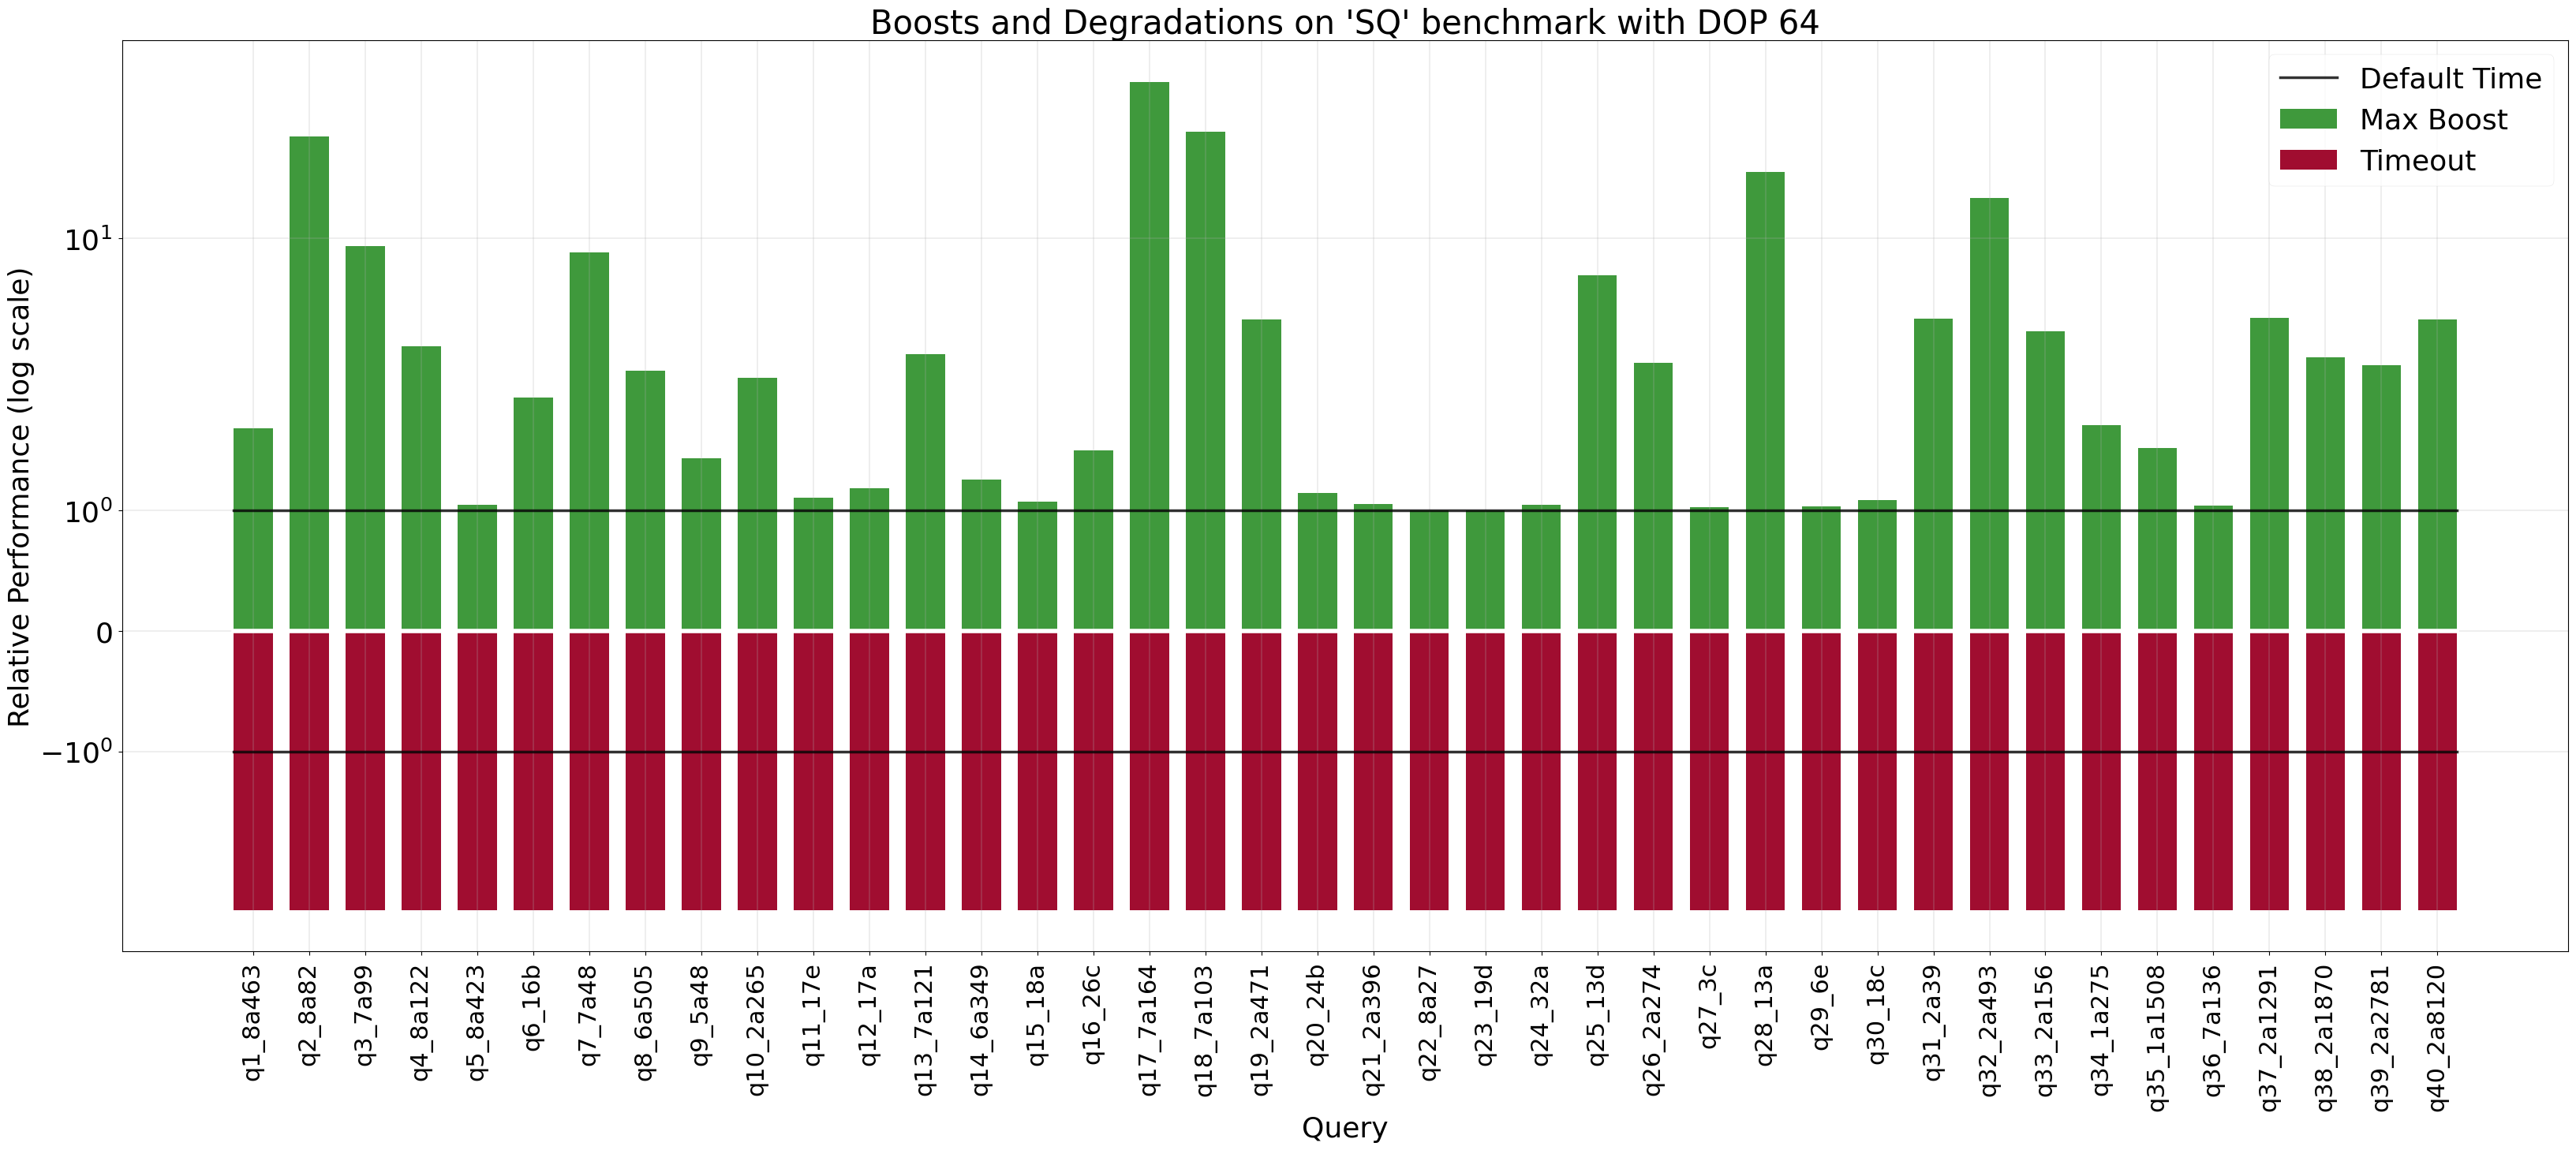

In [76]:
for bench_name, oracle in cached_oracles.items():
    def_times, best_times = [], []
    for dop in query_dops:
        names, boosts, degradations = [], [], []
        for query_name in sorted(oracle.get_query_names(), key=_extract_query_number):
            
            best_hintset = get_best_hintset(
                oracle=oracle, 
                query_name=query_name, 
                possible_hintsets=HINTSETS, 
                dop=dop
            )
            worst_hintset = get_worst_hintset(
                oracle=oracle, 
                query_name=query_name, 
                possible_hintsets=HINTSETS, 
                dop=dop
            )            
            best_request = OracleRequest(query_name=query_name, hintset=best_hintset, dop=dop)
            def_request = OracleRequest(query_name=query_name, hintset=DEFAULT_HINTSET, dop=dop)
            worst_request = OracleRequest(query_name=query_name, hintset=worst_hintset, dop=dop)

            best_time = oracle.get_execution_time(best_request)
            def_time = oracle.get_execution_time(def_request)
            worst_time = oracle.get_execution_time(worst_request)
        
            names.append(query_name)
            boosts.append(def_time / best_time)
            if worst_time == TIMEOUT:
                degradations.append(TIMEOUT_REL)    
            else:
                degradations.append(worst_time / def_time)

        bench_title = bench_to_title[bench_name]
        plot_per_query_bars(
            names=names,
            boosts=boosts,
            degradations=degradations,
            title=f"Boosts and Degradations on '{bench_title}' benchmark with DOP {dop}",
            path_to_save=f"{EXPERIMENT_PATH}/artifacts/{bench_title}_{dop}_per_query.png"
        )

# Conclusions

E2E performance in the best case is about x1.5 - x5. 
In the worst case hintset can lead to degradation (timeout for almost all queries!)

P.S. queries `13b` and `13c` ingore hints (planner always prefer default plan)